## Проект. Прогнозирование временных рядов. Новопольский Артём

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation
import itertools
import warnings
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')
sns.set(palette='bright')

Importing plotly failed. Interactive plots will not work.


## Описание задания

Сравнить качество прогноза по изученным методам по метрикам `MAPE` и `MAE`.

**Датасет**: [COVID 19](https://www.kaggle.com/c/covid19-global-forecasting-week-4/data?select=train.csv).

Исследовать поля `ConfirmedCases` и `Fatalities` (тотал и отдельно Россию).

## Актуальность
Модели временных рядов активно применяются в исследованиях значительного числа реальных процессов. Например, в исследованиях спроса на различные виды продукции, финансовых рынков, в анализе динамики финансовых показателей, прогнозировании цен на различные товары.

В современном мире аналитику необходимо владеть инструментарием для работы с временными рядами, именно поэтому в качестве проекта была выбрана тема прогнозирования временных рядов COVID-19.

## Выбор методологии
В качестве инструмента для прогнозирования был выбран метод `Prophet`, разработанный компанией Facebook (ныне Meta). 

Мы можем рассматривать `Prophet` как расширение базовых авторегрессионных моделей. Вместо того, чтобы просто использовать лаговые значения целевой переменной, модель предоставляет дополнительную форму конструирования признаков — она применяет **ряд Фурье к входной переменной**. Это позволяет нам дополнительно поднастраивать модель для повышения производительности. `Prophet` имеет множество других полезных функций, некоторые из которых перечислены ниже:

* `Prophet` может использовать дополнительные внешние регрессоры;

* Модель может автоматически обнаруживать поворотные точки в тенденции — например, когда возрастающая тенденция становится убывающей;

* Модель может учитывать эффект праздников.

Помимо этого, преимуществами использования `Prophet` являются хорошая производительность, а также простота установки и использования.

## Импорт и предобработка данных

In [2]:
covid_data = pd.read_csv('../data/covid19.csv', sep=',')
covid_data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


Заметим в данных столбец `Id`, который является идентификатором записей, и столбец `Province_State`, в котором присутствуют пропущенные значения. Поскольку в рамках задачи нам не нужно работать с идентификаторами записей и конкретными регионами стран, можем от них избавиться.

In [3]:
covid_data = covid_data[['Country_Region', 'Date', 'ConfirmedCases', 'Fatalities']]
covid_data.head()

,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,2020-01-26,0.0,0.0


Убедимся, что в преобразованном наборе данных отсутствуют пропущенные значения:

In [4]:
covid_data.isna().values.sum() == 0

True

Также проверим типы данных и в случае необходимости приведём к нужному виду:

In [5]:
covid_data.dtypes

Country_Region     object
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object

In [6]:
covid_data.Date = pd.to_datetime(covid_data.Date)
covid_data.head()

,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,2020-01-26,0.0,0.0


Получим из датасета кумулятивные данные по всем странам:

In [7]:
covid_total = covid_data.groupby('Date').sum().reset_index(level=0)
covid_total.head()

,Date,ConfirmedCases,Fatalities
0,2020-01-22,554.0,17.0
1,2020-01-23,653.0,18.0
2,2020-01-24,939.0,26.0
3,2020-01-25,1432.0,42.0
4,2020-01-26,2113.0,56.0


Получим данные отдельно по России:

In [8]:
covid_rus = covid_data.loc[covid_data.Country_Region == 'Russia'].reset_index().drop(['index', 'Country_Region'], axis=1)
covid_rus.head()

,Date,ConfirmedCases,Fatalities
0,2020-01-22,0.0,0.0
1,2020-01-23,0.0,0.0
2,2020-01-24,0.0,0.0
3,2020-01-25,0.0,0.0
4,2020-01-26,0.0,0.0


## Виузализация данных

Посмотрим, что представляют данные с помощью графиков. Также на графики добавим линию, которая разделяет наши данные на обучающую выборку и выборку, для которой нужно сделать прогноз.

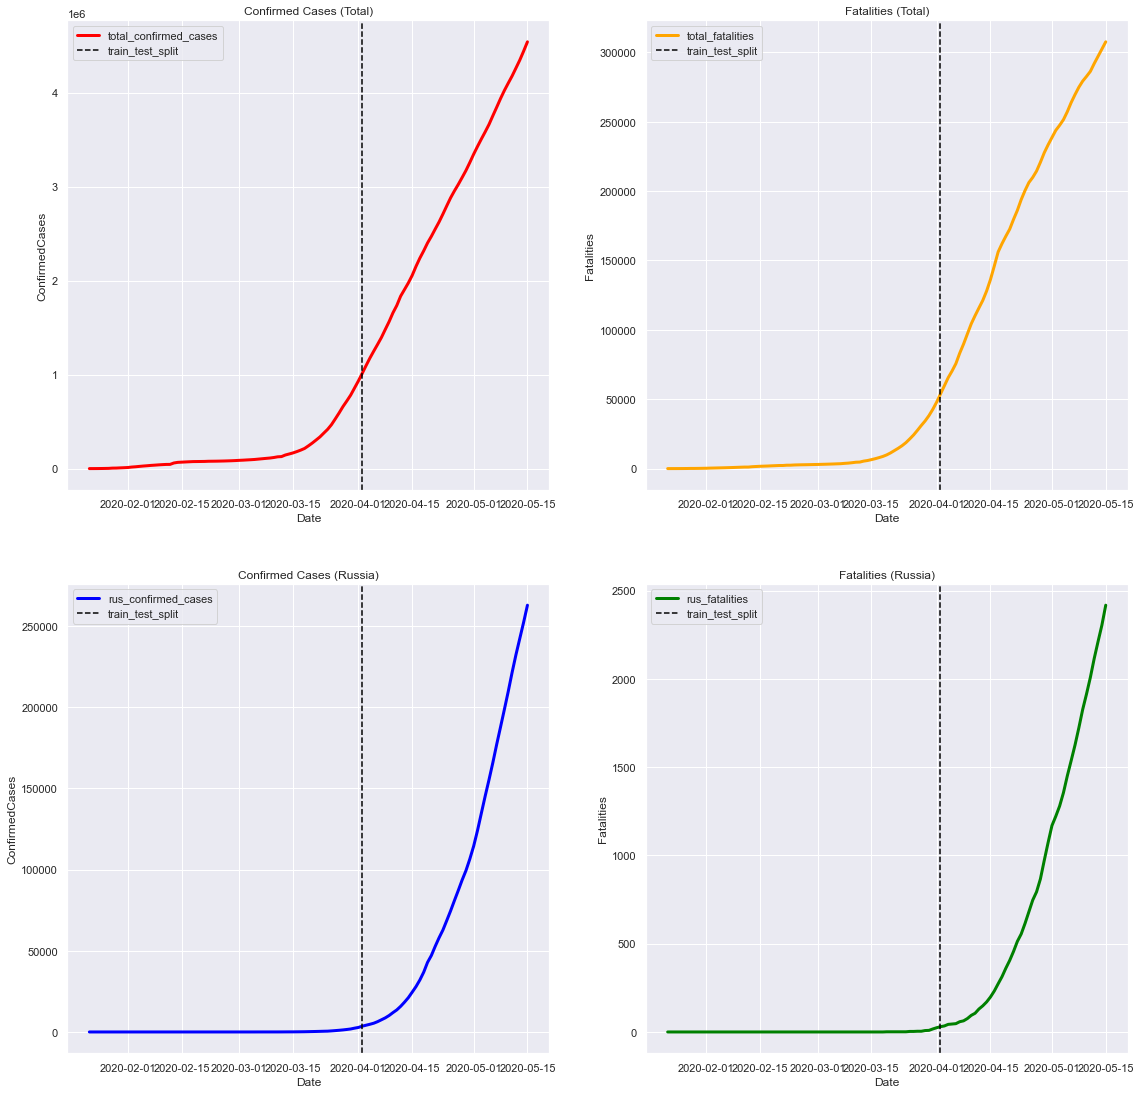

In [9]:
def show_time_series_plot(total, rus):
    """ Визуализация метрик за исследуемый период. """
    fig, axes = plt.subplots(2, 2, figsize=(19, 19))
    
    # Тотал
    sns.lineplot(total.Date, total.ConfirmedCases, 
                 ax=axes[0, 0], label='total_confirmed_cases',
                 color='red', linewidth=3)
    axes[0, 0].axvline(x=pd.to_datetime('2020-04-02'), linestyle = '--',
                       color='black', label='train_test_split')
    axes[0, 0].set_title('Confirmed Cases (Total)')
    axes[0, 0].legend()
    
    sns.lineplot(total.Date, total.Fatalities, 
                 ax=axes[0, 1], label='total_fatalities', 
                 color='orange', linewidth=3)
    axes[0, 1].axvline(x=pd.to_datetime('2020-04-02'), linestyle = '--',
                       color='black', label='train_test_split')
    axes[0, 1].set_title('Fatalities (Total)')
    axes[0, 1].legend()
    
    # Россия
    sns.lineplot(rus.Date, rus.ConfirmedCases, 
                 ax=axes[1, 0], label='rus_confirmed_cases', 
                 color='blue', linewidth=3)
    axes[1, 0].axvline(x=pd.to_datetime('2020-04-02'), linestyle = '--',
                       color='black', label='train_test_split')
    axes[1, 0].set_title('Confirmed Cases (Russia)')
    axes[1, 0].legend()
    
    sns.lineplot(rus.Date, rus.Fatalities, 
                 ax=axes[1, 1], label='rus_fatalities', 
                 color='green', linewidth=3)
    axes[1, 1].axvline(x=pd.to_datetime('2020-04-02'), linestyle = '--',
                       color='black', label='train_test_split')
    axes[1, 1].set_title('Fatalities (Russia)')
    axes[1, 1].legend()
    
    plt.show()


show_time_series_plot(covid_total, covid_rus)

### Интерпретация графиков

На каждом из графиков явно присутствует трендовая компонента и отсутствуют колебания, связанные с сезонностью. Также важно заметить, что каждый из графиков имеет точку изменения тренда.

## Prophet
Определим функцию `prepare_df_for_prophet`, которая приведет данные к формату, необходимому для обучения модели. 

Будем делать прогноз на 43 дня (со 2 апреля по 14 мая 2020). Поэтому от сформированных датасетов для Prophet "отрежем" это количество измерений, чтобы затем измерить на них качество.

In [10]:
def prepare_df_for_prophet(df, columns=['Date', 'Fatalities']):
    """ Приведение DataFrame к формату, необходимого для Prophet. """ 
    df = df[columns]
    df.columns = ['ds', 'y']
    return df


covid_total_confcases = prepare_df_for_prophet(covid_total, columns=['Date', 'ConfirmedCases'])
covid_total_fatalities = prepare_df_for_prophet(covid_total, columns=['Date', 'Fatalities'])
covid_rus_confcases = prepare_df_for_prophet(covid_rus, columns=['Date', 'ConfirmedCases'])
covid_rus_fatalities = prepare_df_for_prophet(covid_rus, columns=['Date', 'Fatalities'])

predictions = 43
train_covid_total_confcases = covid_total_confcases[:-predictions]
train_covid_total_fatalities = covid_total_fatalities[:-predictions]
train_covid_rus_confcases = covid_rus_confcases[:-predictions]
train_covid_rus_fatalities = covid_rus_fatalities[:-predictions]

Также для удобства создадим функцию, которая будет отвечать за создание, обучение и расчёт прогноза модели `Prophet`.

In [11]:
def calc_prophet_forecast(data, params=None, predictions=43):
    """ Создание, обучение и расчёт прогноза модели Prophet. """
    if params:
        model = Prophet(**params)
    else:
        model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=predictions)
    forecast = model.predict(future)
    return model, forecast

А также создадим функцию `calc_mae_and_mape_metrics`, которая поможет нам в расчёте метрик качества полученных моделей:

In [12]:
def calc_mae_and_mape_metrics(data, forecast, predictions=43):
    """ Расчёт метрик MAE и MAPE. """
    compare_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data.set_index('ds'))
    compare_df['error'] = compare_df['y'] - compare_df['yhat']
    compare_df['percent_error'] = 100 * compare_df['error'] / compare_df['y']

    print('MAPE =', np.mean(abs(compare_df[-predictions:]['percent_error'])), '%')
    print('MAE =', np.mean(abs(compare_df[-predictions:]['error'])))

### Total Confirmed Cases
Начнем с прогнозирования заболеваний по всему миру.

#### Baseline
Для начала обучим модель `Prophet` без подбора гиперпараметров и будем использовать её как baseline.

In [13]:
model, forecast = calc_prophet_forecast(train_covid_total_confcases)


Initial log joint probability = -40.306
Iteration  1. Log joint probability =    47.5808. Improved by 87.8869.
Iteration  2. Log joint probability =    85.9229. Improved by 38.3421.
Iteration  3. Log joint probability =     102.94. Improved by 17.017.
Iteration  4. Log joint probability =    103.832. Improved by 0.891967.
Iteration  5. Log joint probability =    103.868. Improved by 0.0365752.
Iteration  6. Log joint probability =    103.884. Improved by 0.0150564.
Iteration  7. Log joint probability =     103.93. Improved by 0.0463861.
Iteration  8. Log joint probability =    103.939. Improved by 0.00941381.
Iteration  9. Log joint probability =    103.991. Improved by 0.0521185.
Iteration 10. Log joint probability =    104.174. Improved by 0.182664.
Iteration 11. Log joint probability =     104.42. Improved by 0.245616.
Iteration 12. Log joint probability =    104.663. Improved by 0.242918.
Iteration 13. Log joint probability =    105.811. Improved by 1.14873.
Iteration 14. Log join

Сравним прогноз с реальными значениями. Заметим, что имеются расхождения.

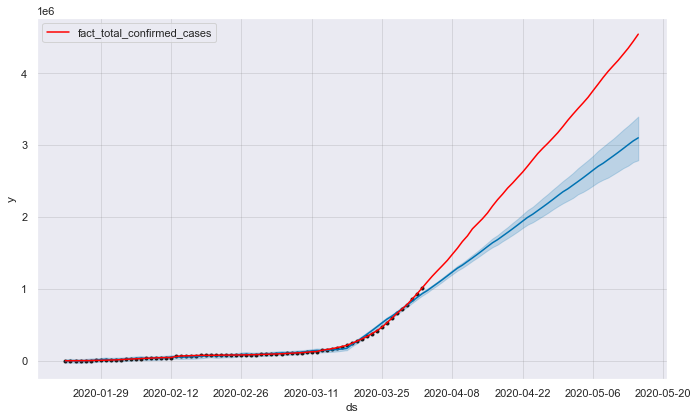

In [14]:
model.plot(forecast)
sns.lineplot(covid_total_confcases.ds, covid_total_confcases.y, color='red', label='fact_total_confirmed_cases');

Посмотрим на компоненты, которые выделил `Prophet` в автоматическом режиме:

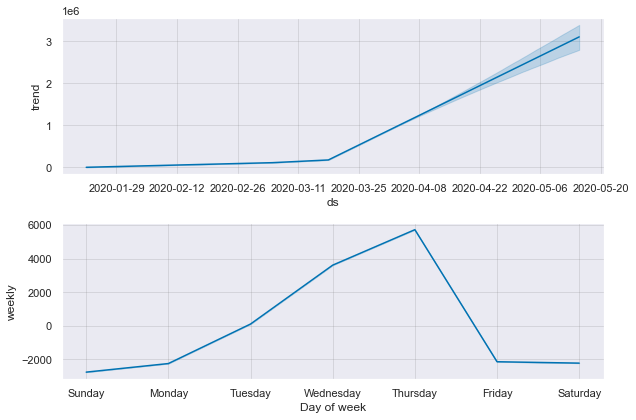

In [15]:
model.plot_components(forecast);

Как видим, `Prophet` определил в данных недельную сезонность, хотя на графике исходных данных её трудно заметить, учтём это при настройке гиперпараметров. Возможно наша модель будет лучшего качества, если исключить из неё сезонные компоненты.

Рассчитаем **MAE** и **MAPE** для полученного прогноза:

In [16]:
calc_mae_and_mape_metrics(covid_total_confcases, forecast)

MAPE = 25.07376942364106 %
MAE = 751987.9355101734


Итак, мы определили baseline для показателя `ConfirmedCases`, рассчитанного по всем странам.

Перейдем к улучшению качества модели: займёмся подбором гиперпараметров с кросс-валидацией.

#### Тюнинг гиперпараметров и кросс-валидация

Для начала создадим функцию `tune_hyperparameters_with_crossval`, которая будет отвечать за процесс подбора параметров. Функция принимает на вход исходные данные и сетку параметров.

Чтобы подбор параметров был более "честным", добавим кросс-валидацию. Так как временной ряд довольно мал, а горизонт прогнозирования высок, в качестве периода будем использовать 3 дня.

In [17]:
def tune_hyperparameters_with_crossval(data, param_grid):
    """ Настройка гиперпараметров с кросс-валидацией. """
    
    # Генерируем все комбинации параметров
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    maes = []; mapes = []

    # Используем кросс-валидацию, чтобы оценить все параметры
    for params in tqdm(all_params):
        model = Prophet(**params).fit(data)
        df_crossval = cross_validation(model, parallel='processes',
                                       initial='65 days', period='3 days', horizon='43 days')
        df_metrics = performance_metrics(df_crossval, rolling_window=1, metrics=['mae', 'mape'])
        maes.append(df_metrics['mae'].values[0])
        mapes.append(df_metrics['mape'].values[0])

    # Определяем лучшие параметры
    best_params = all_params[np.argmin(mapes)]
    return best_params, np.min(maes), np.min(mapes)

Вспомним, что на графике исходных данных была замечена точка перелома тренда. Попробуем добавить это знание в нашу модель с помощью параметра `changepoints`. 

Параметр `changepoint_prior_scale` определяет гибкость тренда и, в частности, насколько сильно тренд меняется в точках изменения тренда. На графике исходных данных можно заметить, что тренд сильно меняет направление, поэтому попробуем учесть и этот параметр.

Также вспомним, что в исходных данных не наблюдалась недельная сезонность, которую *Prophet* включил в нашу baseline-модель. Попробуем "поиграться" с ней при помощи параметра `weekly_seasonality`.

In [18]:
param_grid = {
    'changepoints': [['2020-03-22'], ['2020-03-23'], ['2020-03-24']],
    'changepoint_prior_scale': [0.05, 0.1, 0.25, 0.5],
    'weekly_seasonality': [True, False],
}

params, mae, mape = tune_hyperparameters_with_crossval(covid_total_confcases, param_grid)

  0%|                                                    | 0/24 [00:00<?, ?it/s]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51        466.73   2.66214e-05       0.33218           1           1       63   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -95.5681
Iteration  1. Log joint probability =    47.6139. Improved by 143.182.
Iteration  2. Log joint probability =    86.0175. Improved by 38.4036.
Iteration  3. Log joint probability =    102.988. Improved by 16.9701.
Iteration  4. Log joint probability =    103.845. Improved by 0.857012.
Iteration  5. Log joint probability =    103.849. Improved by 0.00392884.
Iteration  6. Log joint probability =    103.849. Improved by 0.00067657.
Iteration  7. Log joint probability =    103.854. Improved by 0.00522712.
Iteration  8. Log joint probability =    103.857. Improved by 0.00283224.
Iteration  9. Log joint probability =    103.857. Improved by 3.81879e-06.
Iteration 10. Log joint probability =    103.857. Improved by 9.29811e-05.
Iteration 11. Log joint probability =    103.857. Improved by 1.16198e-05.
Iteration 12. Log joint probability =    103.857. Improved by 5.80971e-06.
Iteration 13. Log joint probability =    103.857. Improved by 3.63101e-07.
It

  4%|█▊                                          | 1/24 [00:01<00:37,  1.61s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      30        466.02   4.05577e-06      0.233504      0.8965      0.8965       47   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -73.9458
Iteration  1. Log joint probability =    41.2354. Improved by 115.181.
Iteration  2. Log joint probability =    65.6419. Improved by 24.4065.
Iteration  3. Log joint probability =    101.819. Improved by 36.1775.
Iteration  4. Log joint probability =    102.451. Improved by 0.631908.
Iteration  5. Log joint probability =    102.804. Improved by 0.352193.
Iteration  6. Log joint probability =    102.809. Improved by 0.00544501.
Iteration  7. Log joint probability =     102.81. Improved by 0.00103227.
Iteration  8. Log joint probability =     102.81. Improved by 0.00010266.
Iteration  9. Log joint probability =     102.81. Improved by 5.92274e-05.
Iteration 10. Log joint probability =     102.81. Improved by 3.52618e-05.
Iteration 11. Log joint probability =     102.81. Improved by 5.20333e-06.
Iteration 12. Log joint probability =     102.81. Improved by 1.6119e-05.
Iteration 13. Log joint probability =     102.81. Improved by 5.03718e-07.
Itera

  8%|███▋                                        | 2/24 [00:03<00:36,  1.67s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55        485.78   6.09115e-05      0.650796      0.8669      0.8669       68   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -93.0492
Iteration  1. Log joint probability =    42.0454. Improved by 135.095.
Iteration  2. Log joint probability =    57.1357. Improved by 15.0903.
Iteration  3. Log joint probability =    61.9667. Improved by 4.83102.
Iteration  4. Log joint probability =    86.1345. Improved by 24.1677.
Iteration  5. Log joint probability =    102.488. Improved by 16.3532.
Iteration  6. Log joint probability =    102.858. Improved by 0.370081.
Iteration  7. Log joint probability =    112.356. Improved by 9.49807.
Iteration  8. Log joint probability =    122.201. Improved by 9.84543.
Iteration  9. Log joint probability =    122.842. Improved by 0.640389.
Iteration 10. Log joint probability =    122.842. Improved by 0.000748141.
Iteration 11. Log joint probability =    122.843. Improved by 0.000333931.
Iteration 12. Log joint probability =    122.843. Improved by 0.000484094.
Iteration 13. Log joint probability =    122.843. Improved by 0.000241673.
Iteration 14. Log

 12%|█████▌                                      | 3/24 [00:05<00:35,  1.69s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34        485.07   6.30185e-05      0.041843           1           1       46   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -71.3057
Iteration  1. Log joint probability =    10.3984. Improved by 81.7041.
Iteration  2. Log joint probability =    33.2593. Improved by 22.861.
Iteration  3. Log joint probability =    104.698. Improved by 71.4384.
Iteration  4. Log joint probability =    105.575. Improved by 0.877368.
Iteration  5. Log joint probability =    105.576. Improved by 0.00130741.
Iteration  6. Log joint probability =    105.581. Improved by 0.00466884.
Iteration  7. Log joint probability =    105.597. Improved by 0.0155873.
Iteration  8. Log joint probability =    105.598. Improved by 0.00128282.
Iteration  9. Log joint probability =    105.599. Improved by 0.000901957.
Iteration 10. Log joint probability =      105.6. Improved by 0.00138033.
Iteration 11. Log joint probability =      105.6. Improved by 3.33655e-05.
Iteration 12. Log joint probability =    105.601. Improved by 0.000323128.
Iteration 13. Log joint probability =    105.601. Improved by 0.000172528.
Itera

 17%|███████▎                                    | 4/24 [00:06<00:33,  1.68s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37       497.215   7.33271e-05      0.490323           1           1       56   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -90.6322
Iteration  1. Log joint probability =    16.1531. Improved by 106.785.
Iteration  2. Log joint probability =    84.2784. Improved by 68.1253.
Iteration  3. Log joint probability =     104.53. Improved by 20.2519.
Iteration  4. Log joint probability =    106.243. Improved by 1.71253.
Iteration  5. Log joint probability =    106.297. Improved by 0.0546291.
Iteration  6. Log joint probability =    106.301. Improved by 0.0034139.
Iteration  7. Log joint probability =    118.876. Improved by 12.5751.
Iteration  8. Log joint probability =    118.959. Improved by 0.0828839.
Iteration  9. Log joint probability =     120.76. Improved by 1.80143.
Iteration 10. Log joint probability =    121.272. Improved by 0.512195.
Iteration 11. Log joint probability =    121.962. Improved by 0.68912.
Iteration 12. Log joint probability =    122.237. Improved by 0.275483.
Iteration 13. Log joint probability =    122.593. Improved by 0.356173.
Iteration 14. Log joint pr

 21%|█████████▏                                  | 5/24 [00:08<00:31,  1.68s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      31       496.504   0.000261477     0.0722837           1           1       46   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -72.222
Iteration  1. Log joint probability =    10.3986. Improved by 82.6207.
Iteration  2. Log joint probability =    33.2642. Improved by 22.8656.
Iteration  3. Log joint probability =    104.699. Improved by 71.4344.
Iteration  4. Log joint probability =    105.582. Improved by 0.883293.
Iteration  5. Log joint probability =    105.598. Improved by 0.0162234.
Iteration  6. Log joint probability =    113.327. Improved by 7.7286.
Iteration  7. Log joint probability =    118.164. Improved by 4.83741.
Iteration  8. Log joint probability =     121.11. Improved by 2.94602.
Iteration  9. Log joint probability =    121.203. Improved by 0.0928586.
Iteration 10. Log joint probability =    121.985. Improved by 0.781846.
Iteration 11. Log joint probability =    122.166. Improved by 0.181339.
Iteration 12. Log joint probability =    122.541. Improved by 0.374702.
Iteration 13. Log joint probability =    122.675. Improved by 0.134582.
Iteration 14. Log joint prob

 25%|███████████                                 | 6/24 [00:10<00:30,  1.70s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       501.027   4.16513e-05       1.02485      0.6372      0.6372       55   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -91.3254
Iteration  1. Log joint probability =    16.1534. Improved by 107.479.
Iteration  2. Log joint probability =    84.2793. Improved by 68.126.
Iteration  3. Log joint probability =    104.532. Improved by 20.2527.
Iteration  4. Log joint probability =     106.25. Improved by 1.71786.
Iteration  5. Log joint probability =    136.075. Improved by 29.8252.
Iteration  6. Log joint probability =    137.786. Improved by 1.71076.
Iteration  7. Log joint probability =    139.196. Improved by 1.41058.
Iteration  8. Log joint probability =    139.206. Improved by 0.00950579.
Iteration  9. Log joint probability =    139.208. Improved by 0.00205072.
Iteration 10. Log joint probability =    139.214. Improved by 0.00593705.
Iteration 11. Log joint probability =    139.216. Improved by 0.0016954.
Iteration 12. Log joint probability =    139.219. Improved by 0.00375262.
Iteration 13. Log joint probability =    139.221. Improved by 0.00131951.
Iteration 14. Log j

 29%|████████████▊                               | 7/24 [00:11<00:29,  1.71s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       500.317   7.29646e-06      0.057541           1           1       52   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -72.9152
Iteration  1. Log joint probability =     10.399. Improved by 83.3142.
Iteration  2. Log joint probability =    33.2653. Improved by 22.8663.
Iteration  3. Log joint probability =    104.701. Improved by 71.4352.
Iteration  4. Log joint probability =    105.589. Improved by 0.888642.
Iteration  5. Log joint probability =    134.946. Improved by 29.357.
Iteration  6. Log joint probability =    137.467. Improved by 2.52104.
Iteration  7. Log joint probability =    138.972. Improved by 1.50457.
Iteration  8. Log joint probability =    138.983. Improved by 0.0111384.
Iteration  9. Log joint probability =    138.985. Improved by 0.00216915.
Iteration 10. Log joint probability =    138.992. Improved by 0.00693073.
Iteration 11. Log joint probability =    138.994. Improved by 0.00183957.
Iteration 12. Log joint probability =    138.998. Improved by 0.00436654.
Iteration 13. Log joint probability =        139. Improved by 0.00145268.
Iteration 14. Log 

 33%|██████████████▋                             | 8/24 [00:13<00:27,  1.70s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       465.472   1.20379e-05      0.440675      0.6124      0.6124       53   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -89.0228
Iteration  1. Log joint probability =    16.1528. Improved by 105.176.
Iteration  2. Log joint probability =    84.2715. Improved by 68.1187.
Iteration  3. Log joint probability =    104.527. Improved by 20.2555.
Iteration  4. Log joint probability =    106.227. Improved by 1.70037.
Iteration  5. Log joint probability =    106.285. Improved by 0.0571692.
Iteration  6. Log joint probability =    106.362. Improved by 0.0774189.
Iteration  7. Log joint probability =    106.369. Improved by 0.00707711.
Iteration  8. Log joint probability =     106.37. Improved by 0.00127236.
Iteration  9. Log joint probability =    106.371. Improved by 0.00064412.
Iteration 10. Log joint probability =    106.371. Improved by 1.64108e-05.
Iteration 11. Log joint probability =    106.371. Improved by 8.55885e-06.
Iteration 12. Log joint probability =    106.371. Improved by 5.03219e-06.
Iteration 13. Log joint probability =    106.371. Improved by 7.64404e-08.
Iterat

 38%|████████████████▌                           | 9/24 [00:15<00:25,  1.70s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       465.084   1.38496e-05      0.509589      0.9537      0.9537       50   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -77.1579
Iteration  1. Log joint probability =    47.4638. Improved by 124.622.
Iteration  2. Log joint probability =    84.0227. Improved by 36.5589.
Iteration  3. Log joint probability =    102.268. Improved by 18.2449.
Iteration  4. Log joint probability =    102.322. Improved by 0.0542327.
Iteration  5. Log joint probability =    102.631. Improved by 0.309284.
Iteration  6. Log joint probability =    102.703. Improved by 0.0717094.
Iteration  7. Log joint probability =    102.716. Improved by 0.0131095.
Iteration  8. Log joint probability =    102.892. Improved by 0.176029.
Iteration  9. Log joint probability =    102.938. Improved by 0.0462869.
Iteration 10. Log joint probability =    102.952. Improved by 0.0134335.
Iteration 11. Log joint probability =    103.062. Improved by 0.109959.
Iteration 12. Log joint probability =    103.094. Improved by 0.0322511.
Iteration 13. Log joint probability =    103.157. Improved by 0.0626189.
Iteration 14. Log 

 42%|█████████████████▉                         | 10/24 [00:16<00:24,  1.72s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       484.583    3.8447e-06      0.798917      0.1563      0.1563       60   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -89.716
Iteration  1. Log joint probability =    16.1528. Improved by 105.869.
Iteration  2. Log joint probability =    84.2756. Improved by 68.1228.
Iteration  3. Log joint probability =    104.529. Improved by 20.2538.
Iteration  4. Log joint probability =    106.235. Improved by 1.70517.
Iteration  5. Log joint probability =    106.342. Improved by 0.10708.
Iteration  6. Log joint probability =    106.358. Improved by 0.0167774.
Iteration  7. Log joint probability =    106.366. Improved by 0.00779448.
Iteration  8. Log joint probability =    106.369. Improved by 0.00312759.
Iteration  9. Log joint probability =    106.371. Improved by 0.00147414.
Iteration 10. Log joint probability =    106.371. Improved by 1.78229e-05.
Iteration 11. Log joint probability =    106.371. Improved by 5.60264e-05.
Iteration 12. Log joint probability =    106.371. Improved by 4.47382e-05.
Iteration 13. Log joint probability =    106.371. Improved by 1.1181e-05.
Iteration 

 46%|███████████████████▋                       | 11/24 [00:18<00:22,  1.74s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      33       484.194   2.01213e-05      0.467733           1           1       49   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -71.3057
Iteration  1. Log joint probability =    10.3983. Improved by 81.7041.
Iteration  2. Log joint probability =    33.2582. Improved by 22.8599.
Iteration  3. Log joint probability =    104.696. Improved by 71.4383.
Iteration  4. Log joint probability =    105.574. Improved by 0.877263.
Iteration  5. Log joint probability =    105.587. Improved by 0.0134282.
Iteration  6. Log joint probability =    105.597. Improved by 0.00984339.
Iteration  7. Log joint probability =      105.6. Improved by 0.00276263.
Iteration  8. Log joint probability =      105.6. Improved by 0.000685439.
Iteration  9. Log joint probability =    105.601. Improved by 7.94063e-05.
Iteration 10. Log joint probability =    105.601. Improved by 5.31084e-05.
Iteration 11. Log joint probability =    105.601. Improved by 4.22065e-05.
Iteration 12. Log joint probability =    105.601. Improved by 2.40501e-05.
Iteration 13. Log joint probability =    105.601. Improved by 2.3607e-05.
Ite

 50%|█████████████████████▌                     | 12/24 [00:20<00:21,  1.77s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       496.053   1.30349e-05      0.544065      0.7772      0.7772       56   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -90.6322
Iteration  1. Log joint probability =    16.1529. Improved by 106.785.
Iteration  2. Log joint probability =    84.2782. Improved by 68.1253.
Iteration  3. Log joint probability =     104.53. Improved by 20.2514.
Iteration  4. Log joint probability =    106.241. Improved by 1.71181.
Iteration  5. Log joint probability =    106.295. Improved by 0.0532558.
Iteration  6. Log joint probability =    106.371. Improved by 0.0763835.
Iteration  7. Log joint probability =    106.371. Improved by 4.15349e-06.
Iteration  8. Log joint probability =    106.371. Improved by 9.46938e-06.
Iteration  9. Log joint probability =    106.371. Improved by 8.95549e-06.
Iteration 10. Log joint probability =    106.371. Improved by 8.34999e-06.
Iteration 11. Log joint probability =    106.371. Improved by 7.98799e-06.
Iteration 12. Log joint probability =    106.371. Improved by 7.58821e-06.
Iteration 13. Log joint probability =    106.371. Improved by 7.33531e-06.
Ite

 54%|███████████████████████▎                   | 13/24 [00:22<00:19,  1.79s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       495.665   0.000146051      0.233466           1           1       48   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -72.222
Iteration  1. Log joint probability =    10.3984. Improved by 82.6205.
Iteration  2. Log joint probability =    33.2631. Improved by 22.8646.
Iteration  3. Log joint probability =    104.698. Improved by 71.4348.
Iteration  4. Log joint probability =     105.58. Improved by 0.882162.
Iteration  5. Log joint probability =    105.586. Improved by 0.00585747.
Iteration  6. Log joint probability =    105.587. Improved by 0.00114251.
Iteration  7. Log joint probability =    105.591. Improved by 0.0036538.
Iteration  8. Log joint probability =    105.592. Improved by 0.000975385.
Iteration  9. Log joint probability =    105.594. Improved by 0.0023094.
Iteration 10. Log joint probability =    105.595. Improved by 0.000775723.
Iteration 11. Log joint probability =    105.596. Improved by 0.00147736.
Iteration 12. Log joint probability =    105.597. Improved by 0.000592398.
Iteration 13. Log joint probability =    105.598. Improved by 0.0010581.
Iteratio

 58%|█████████████████████████                  | 14/24 [00:24<00:18,  1.86s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       499.877   1.69146e-05      0.223854      0.8933      0.8933       55   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -97.8707
Iteration  1. Log joint probability =    47.6141. Improved by 145.485.
Iteration  2. Log joint probability =    86.0178. Improved by 38.4037.
Iteration  3. Log joint probability =    103.018. Improved by 17.0001.
Iteration  4. Log joint probability =    159.809. Improved by 56.791.
Iteration  5. Log joint probability =     182.51. Improved by 22.7008.
Iteration  6. Log joint probability =    183.586. Improved by 1.07608.
Iteration  7. Log joint probability =    184.135. Improved by 0.549244.
Iteration  8. Log joint probability =    184.135. Improved by 0.000380705.
Iteration  9. Log joint probability =    184.136. Improved by 0.000216499.
Iteration 10. Log joint probability =    184.136. Improved by 0.00025039.
Iteration 11. Log joint probability =    184.136. Improved by 0.000152111.
Iteration 12. Log joint probability =    184.136. Improved by 0.000165476.
Iteration 13. Log joint probability =    184.136. Improved by 0.000106106.
Iteration 14

 62%|██████████████████████████▉                | 15/24 [00:26<00:16,  1.85s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      33       499.489   1.51914e-05      0.833626      0.6532      0.6532       45   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -72.9152
Iteration  1. Log joint probability =    10.3987. Improved by 83.3139.
Iteration  2. Log joint probability =    33.2647. Improved by 22.866.
Iteration  3. Log joint probability =      104.7. Improved by 71.4351.
Iteration  4. Log joint probability =    105.591. Improved by 0.890951.
Iteration  5. Log joint probability =    122.019. Improved by 16.4282.
Iteration  6. Log joint probability =    122.901. Improved by 0.882052.
Iteration  7. Log joint probability =    124.398. Improved by 1.49742.
Iteration  8. Log joint probability =    124.707. Improved by 0.308912.
Iteration  9. Log joint probability =    124.708. Improved by 0.000910006.
Iteration 10. Log joint probability =    124.709. Improved by 0.000337695.
Iteration 11. Log joint probability =    124.709. Improved by 0.000583227.
Iteration 12. Log joint probability =    124.709. Improved by 0.000251282.
Iteration 13. Log joint probability =     124.71. Improved by 0.000376889.
Iteration 14.

 67%|████████████████████████████▋              | 16/24 [00:28<00:14,  1.82s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        443.93   8.42899e-05      0.651128           1           1       74   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -89.0228
Iteration  1. Log joint probability =    16.1528. Improved by 105.176.
Iteration  2. Log joint probability =    84.2715. Improved by 68.1187.
Iteration  3. Log joint probability =    104.526. Improved by 20.2549.
Iteration  4. Log joint probability =    106.228. Improved by 1.70138.
Iteration  5. Log joint probability =     106.28. Improved by 0.0524674.
Iteration  6. Log joint probability =    106.366. Improved by 0.0857258.
Iteration  7. Log joint probability =     106.37. Improved by 0.00354044.
Iteration  8. Log joint probability =     106.37. Improved by 0.000614921.
Iteration  9. Log joint probability =    106.371. Improved by 0.000770405.
Iteration 10. Log joint probability =    106.371. Improved by 9.63005e-05.
Iteration 11. Log joint probability =    106.371. Improved by 2.18412e-06.
Iteration 12. Log joint probability =    106.371. Improved by 3.34999e-07.
Iteration 13. Log joint probability =    106.371. Improved by 5.88564e-08.
Iter

 71%|██████████████████████████████▍            | 17/24 [00:29<00:12,  1.79s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      33       443.766   0.000116755      0.518056           1           1       48   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -77.1579
Iteration  1. Log joint probability =    47.4638. Improved by 124.622.
Iteration  2. Log joint probability =    84.0226. Improved by 36.5588.
Iteration  3. Log joint probability =    102.267. Improved by 18.2446.
Iteration  4. Log joint probability =    102.318. Improved by 0.0511043.
Iteration  5. Log joint probability =    102.624. Improved by 0.305948.
Iteration  6. Log joint probability =    102.631. Improved by 0.00655257.
Iteration  7. Log joint probability =    102.698. Improved by 0.0676235.
Iteration  8. Log joint probability =    102.712. Improved by 0.0134854.
Iteration  9. Log joint probability =    102.891. Improved by 0.178629.
Iteration 10. Log joint probability =    102.934. Improved by 0.043889.
Iteration 11. Log joint probability =    102.937. Improved by 0.00257305.
Iteration 12. Log joint probability =    103.043. Improved by 0.106246.
Iteration 13. Log joint probability =    103.385. Improved by 0.341896.
Iteration 14. Log 

 75%|████████████████████████████████▎          | 18/24 [00:31<00:10,  1.76s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       463.098   1.03527e-05     0.0704051           1           1       66   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -93.0492
Iteration  1. Log joint probability =    42.0454. Improved by 135.095.
Iteration  2. Log joint probability =     57.134. Improved by 15.0886.
Iteration  3. Log joint probability =    61.9635. Improved by 4.82949.
Iteration  4. Log joint probability =    86.1349. Improved by 24.1714.
Iteration  5. Log joint probability =    102.527. Improved by 16.3925.
Iteration  6. Log joint probability =    103.298. Improved by 0.770448.
Iteration  7. Log joint probability =    103.298. Improved by 0.000511717.
Iteration  8. Log joint probability =    103.301. Improved by 0.00230114.
Iteration  9. Log joint probability =    103.302. Improved by 0.00100095.
Iteration 10. Log joint probability =    103.302. Improved by 0.000498807.
Iteration 11. Log joint probability =    103.302. Improved by 3.11761e-05.
Iteration 12. Log joint probability =    103.302. Improved by 1.55881e-05.
Iteration 13. Log joint probability =    103.302. Improved by 7.00892e-07.
Iteratio

 79%|██████████████████████████████████         | 19/24 [00:33<00:08,  1.75s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       462.935   9.18345e-05      0.424121           1           1       51   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -74.639
Iteration  1. Log joint probability =    41.2354. Improved by 115.874.
Iteration  2. Log joint probability =    65.6448. Improved by 24.4094.
Iteration  3. Log joint probability =    101.821. Improved by 36.1759.
Iteration  4. Log joint probability =    102.467. Improved by 0.646003.
Iteration  5. Log joint probability =    102.805. Improved by 0.338576.
Iteration  6. Log joint probability =     102.81. Improved by 0.00425936.
Iteration  7. Log joint probability =     102.81. Improved by 0.000269602.
Iteration  8. Log joint probability =     102.81. Improved by 5.01163e-06.
Iteration  9. Log joint probability =     102.81. Improved by 0.000168946.
Iteration 10. Log joint probability =     102.81. Improved by 1.25396e-06.
Iteration 11. Log joint probability =     102.81. Improved by 3.13373e-07.
Iteration 12. Log joint probability =     102.81. Improved by 2.85895e-09.

Initial log joint probability = -77.851
Iteration  1. Log joint probability =

 83%|███████████████████████████████████▊       | 20/24 [00:34<00:06,  1.73s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       474.605   2.04677e-05      0.156551      0.6875      0.6875       51   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -90.6322
Iteration  1. Log joint probability =    16.1529. Improved by 106.785.
Iteration  2. Log joint probability =    84.2781. Improved by 68.1252.
Iteration  3. Log joint probability =    104.529. Improved by 20.2514.
Iteration  4. Log joint probability =     106.24. Improved by 1.71078.
Iteration  5. Log joint probability =    106.291. Improved by 0.0508811.
Iteration  6. Log joint probability =    106.293. Improved by 0.0020782.
Iteration  7. Log joint probability =    106.369. Improved by 0.0762104.
Iteration  8. Log joint probability =    106.371. Improved by 0.00133457.
Iteration  9. Log joint probability =    106.371. Improved by 0.000191269.
Iteration 10. Log joint probability =    106.371. Improved by 7.89751e-06.
Iteration 11. Log joint probability =    106.371. Improved by 1.08935e-05.
Iteration 12. Log joint probability =    106.371. Improved by 1.3894e-05.
Iteration 13. Log joint probability =    106.371. Improved by 2.72968e-06.
Iterati

 88%|█████████████████████████████████████▋     | 21/24 [00:36<00:05,  1.72s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       474.444   0.000151329      0.251782           1           1       44   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -75.5553
Iteration  1. Log joint probability =    41.2356. Improved by 116.791.
Iteration  2. Log joint probability =    65.6476. Improved by 24.412.
Iteration  3. Log joint probability =    101.825. Improved by 36.1778.
Iteration  4. Log joint probability =    102.477. Improved by 0.65176.
Iteration  5. Log joint probability =     102.82. Improved by 0.343266.
Iteration  6. Log joint probability =    121.329. Improved by 18.5089.
Iteration  7. Log joint probability =    125.278. Improved by 3.94909.
Iteration  8. Log joint probability =    125.767. Improved by 0.48861.
Iteration  9. Log joint probability =    125.987. Improved by 0.21979.
Iteration 10. Log joint probability =    125.987. Improved by 0.000316419.
Iteration 11. Log joint probability =    125.987. Improved by 0.000160293.
Iteration 12. Log joint probability =    125.988. Improved by 0.000206497.
Iteration 13. Log joint probability =    125.988. Improved by 0.000114171.
Iteration 14. Log j

 92%|███████████████████████████████████████▍   | 22/24 [00:38<00:03,  1.71s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       478.442   1.38264e-05       0.58841           1           1       53   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -94.6586
Iteration  1. Log joint probability =    42.0456. Improved by 136.704.
Iteration  2. Log joint probability =    57.1371. Improved by 15.0914.
Iteration  3. Log joint probability =    62.0481. Improved by 4.91108.
Iteration  4. Log joint probability =    86.4318. Improved by 24.3837.
Iteration  5. Log joint probability =    126.003. Improved by 39.5712.
Iteration  6. Log joint probability =    137.271. Improved by 11.2685.
Iteration  7. Log joint probability =    140.271. Improved by 2.99998.
Iteration  8. Log joint probability =    141.125. Improved by 0.853521.
Iteration  9. Log joint probability =    141.126. Improved by 0.00116532.
Iteration 10. Log joint probability =    141.127. Improved by 0.000574199.
Iteration 11. Log joint probability =    141.127. Improved by 0.000758917.
Iteration 12. Log joint probability =    141.128. Improved by 0.000410294.
Iteration 13. Log joint probability =    141.128. Improved by 0.000497338.
Iteration 14. L

 96%|█████████████████████████████████████████▏ | 23/24 [00:39<00:01,  1.71s/it]

Initial log joint probability = -6.61268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36       478.281   0.000155216      0.276302           1           1       50   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -79.4604
Iteration  1. Log joint probability =     47.464. Improved by 126.924.
Iteration  2. Log joint probability =    84.0231. Improved by 36.5591.
Iteration  3. Log joint probability =     102.29. Improved by 18.2667.
Iteration  4. Log joint probability =    148.272. Improved by 45.9821.
Iteration  5. Log joint probability =    166.519. Improved by 18.2471.
Iteration  6. Log joint probability =    169.012. Improved by 2.49324.
Iteration  7. Log joint probability =    169.766. Improved by 0.753986.
Iteration  8. Log joint probability =    169.767. Improved by 0.000966362.
Iteration  9. Log joint probability =    169.768. Improved by 0.000462855.
Iteration 10. Log joint probability =    169.768. Improved by 0.000628229.
Iteration 11. Log joint probability =    169.769. Improved by 0.000331932.
Iteration 12. Log joint probability =    169.769. Improved by 0.000411061.
Iteration 13. Log joint probability =    169.769. Improved by 0.000235186.
Iteration 

100%|███████████████████████████████████████████| 24/24 [00:41<00:00,  1.74s/it]


Посмотрим на результаты подбора гиперпараметров:

In [19]:
print('Подобранные параметры:', params)
print('MAE =', mae)
print('MAPE =', mape * 100, '%')

Подобранные параметры: {'changepoints': ['2020-03-22'], 'changepoint_prior_scale': 0.5, 'weekly_seasonality': False}
MAE = 101131.51778049846
MAPE = 3.604892425035596 %


Можем увидеть, что с помощью подбора гиперпараметров и кросс-валидации наши гипотезы о влиянии точки перелома тренда и отсутствии недельной сезонности подтвердились, о чем говорит, например, значение метрики **MAPE**, которая изменилась с 25% в baseline-модели до 3.6%. 

#### Построение модели с подобранными параметрами

Попробуем применить найденные оптимальные параметры и сделать прогноз для наших данных.

In [20]:
model, forecast_total_confcases = calc_prophet_forecast(train_covid_total_confcases, params)


Initial log joint probability = -79.4604
Iteration  1. Log joint probability =    47.4641. Improved by 126.925.
Iteration  2. Log joint probability =    84.0229. Improved by 36.5588.
Iteration  3. Log joint probability =    102.305. Improved by 18.2818.
Iteration  4. Log joint probability =    162.024. Improved by 59.7192.
Iteration  5. Log joint probability =    191.642. Improved by 29.6176.
Iteration  6. Log joint probability =    199.361. Improved by 7.71951.
Iteration  7. Log joint probability =    199.366. Improved by 0.00523777.
Iteration  8. Log joint probability =    199.368. Improved by 0.00141189.
Iteration  9. Log joint probability =    199.371. Improved by 0.00330114.
Iteration 10. Log joint probability =    199.372. Improved by 0.00111134.
Iteration 11. Log joint probability =    199.374. Improved by 0.00210298.
Iteration 12. Log joint probability =    199.375. Improved by 0.000839517.
Iteration 13. Log joint probability =    199.376. Improved by 0.00135214.
Iteration 14.

Посмотрим на график исходных данных и результатов прогноза:

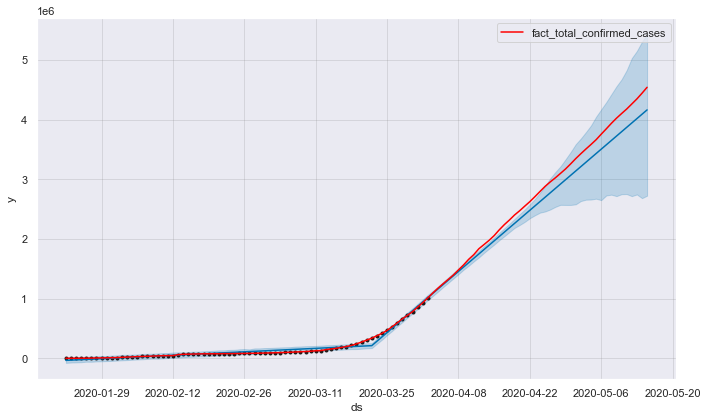

In [21]:
model.plot(forecast_total_confcases)
sns.lineplot(covid_total_confcases.ds, covid_total_confcases.y, color='red', label='fact_total_confirmed_cases');

Видим, что модель действительно стала намного лучше. А что насчет метрик?

In [22]:
calc_mae_and_mape_metrics(covid_total_confcases, forecast_total_confcases)

MAPE = 5.243435018168011 %
MAE = 165721.7139771411


Мы получили MAE = 5.2%, что говорит о качественно проведенном подборе параметров и улучшении качества модели. По сравнению с baseline-моделью прогноз стал точнее в 5 раз. 

### Total Fatalities

Проведём анализ и прогнозирование фатальных случаев по всему миру за исследумый период.

#### Baseline
Начнём также с baseline-модели, которая идёт "из коробки".

In [23]:
model, forecast = calc_prophet_forecast(train_covid_total_fatalities)


Initial log joint probability = -41.3029
Iteration  1. Log joint probability =     11.433. Improved by 52.7359.
Iteration  2. Log joint probability =    82.4289. Improved by 70.9959.
Iteration  3. Log joint probability =    101.254. Improved by 18.8255.
Iteration  4. Log joint probability =    102.164. Improved by 0.90996.
Iteration  5. Log joint probability =    102.239. Improved by 0.0750864.
Iteration  6. Log joint probability =    102.245. Improved by 0.00535456.
Iteration  7. Log joint probability =    102.254. Improved by 0.00947309.
Iteration  8. Log joint probability =    102.259. Improved by 0.00474187.
Iteration  9. Log joint probability =    102.277. Improved by 0.0178671.
Iteration 10. Log joint probability =    102.286. Improved by 0.0095445.
Iteration 11. Log joint probability =    102.488. Improved by 0.201277.
Iteration 12. Log joint probability =    102.566. Improved by 0.0781409.
Iteration 13. Log joint probability =    106.672. Improved by 4.10609.
Iteration 14. Log

Посмотрим на график спрогнозированных и реальных значений:

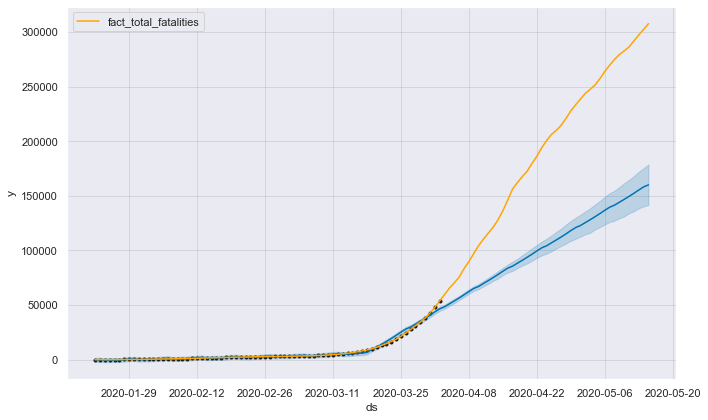

In [24]:
model.plot(forecast)
sns.lineplot(covid_total_fatalities.ds, covid_total_fatalities.y, color='orange', label='fact_total_fatalities');

Видим, что модель даёт очень плохой прогноз. Посмотрим на то, какие компоненты учитывала модель.

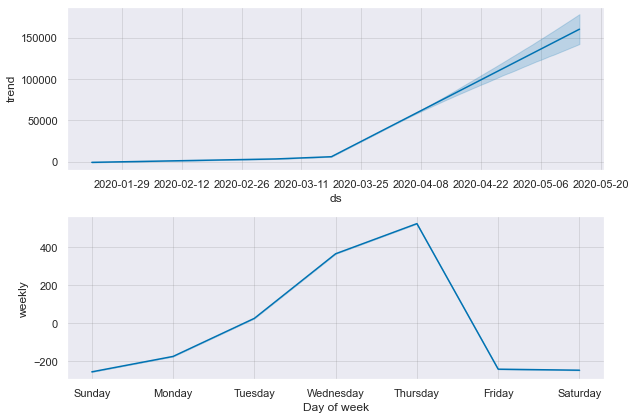

In [25]:
model.plot_components(forecast);

Снова модель распознала в данных недельную сезонность. Чуть позже попробуем выяснить, ухудшает ли модель учёт сезонности, при помощи настройки гиперпараметров. А пока посмотрим на метрики baseline-модели для `Fatalities`, рассчитанного по всему миру.

In [26]:
calc_mae_and_mape_metrics(covid_total_fatalities, forecast)

MAPE = 42.610980149780396 %
MAE = 86888.8726044198


#### Настройка гиперпараметров и кросс-валидация
Модель из коробки оказалось плохого качества. Попробуем настроить гиперпараметры и посмотреть, улучшится ли качество модели. В целом, настраивать будем те же параметры, что и при прогнозировании `ConfirmedCases`. Только исходя из исходного графика немного изменим дату, в которую тренд поменял направление.

In [27]:
param_grid = {
    'changepoints': [['2020-03-23'], ['2020-03-24'], ['2020-03-25']],
    'changepoint_prior_scale': [0.05, 0.1, 0.25, 0.5],
    'weekly_seasonality': [True, False],
}

params, mae, mape = tune_hyperparameters_with_crossval(covid_total_fatalities, param_grid)

  0%|                                                    | 0/24 [00:00<?, ?it/s]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       382.245   1.18394e-05      0.323005      0.5714      0.5714       51   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -89.9084
Iteration  1. Log joint probability =    42.0926. Improved by 132.001.
Iteration  2. Log joint probability =     81.912. Improved by 39.8194.
Iteration  3. Log joint probability =    94.8056. Improved by 12.8936.
Iteration  4. Log joint probability =    97.7579. Improved by 2.9523.
Iteration  5. Log joint probability =    98.0309. Improved by 0.272942.
Iteration  6. Log joint probability =    98.0638. Improved by 0.0329435.
Iteration  7. Log joint probability =     98.167. Improved by 0.103141.
Iteration  8. Log joint probability =    98.7258. Improved by 0.558877.
Iteration  9. Log joint probability =    98.9164. Improved by 0.190531.
Iteration 10. Log joint probability =    99.1479. Improved by 0.231492.
Iteration 11. Log joint probability =    99.3629. Improved by 0.215093.
Iteration 12. Log joint probability =    99.4975. Improved by 0.134559.
Iteration 13. Log joint probability =    99.5171. Improved by 0.0196233.
Iteration 14. Log joint p

  4%|█▊                                          | 1/24 [00:01<00:37,  1.61s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       381.954   1.92279e-05      0.107277           1           1       37   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -78.1548
Iteration  1. Log joint probability =    8.76198. Improved by 86.9168.
Iteration  2. Log joint probability =     81.557. Improved by 72.795.
Iteration  3. Log joint probability =     99.471. Improved by 17.9141.
Iteration  4. Log joint probability =    100.212. Improved by 0.741021.
Iteration  5. Log joint probability =    100.316. Improved by 0.1038.
Iteration  6. Log joint probability =    100.329. Improved by 0.0132396.
Iteration  7. Log joint probability =    100.679. Improved by 0.349987.
Iteration  8. Log joint probability =     100.77. Improved by 0.090594.
Iteration  9. Log joint probability =    100.961. Improved by 0.190842.
Iteration 10. Log joint probability =    100.975. Improved by 0.0143752.
Iteration 11. Log joint probability =    101.048. Improved by 0.0727571.
Iteration 12. Log joint probability =    101.154. Improved by 0.106736.
Iteration 13. Log joint probability =    101.169. Improved by 0.0146316.
Iteration 14. Log joint 

  8%|███▋                                        | 2/24 [00:03<00:36,  1.67s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       403.531    3.6922e-05      0.543195      0.4166           1       44   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -93.9259
Iteration  1. Log joint probability =    40.4326. Improved by 134.359.
Iteration  2. Log joint probability =    80.0196. Improved by 39.587.
Iteration  3. Log joint probability =    97.0166. Improved by 16.997.
Iteration  4. Log joint probability =    97.7929. Improved by 0.776306.
Iteration  5. Log joint probability =    97.7995. Improved by 0.00656673.
Iteration  6. Log joint probability =    98.0121. Improved by 0.212563.
Iteration  7. Log joint probability =    98.3774. Improved by 0.365334.
Iteration  8. Log joint probability =    98.3836. Improved by 0.00624671.
Iteration  9. Log joint probability =    98.5452. Improved by 0.161528.
Iteration 10. Log joint probability =    98.7433. Improved by 0.198183.
Iteration 11. Log joint probability =    98.8526. Improved by 0.109296.
Iteration 12. Log joint probability =    98.8587. Improved by 0.00605909.
Iteration 13. Log joint probability =    98.9796. Improved by 0.120884.
Iteration 14. Log joi

 12%|█████▌                                      | 3/24 [00:05<00:35,  1.69s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       403.241   1.91483e-05      0.407145           1           1       41   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -72.1914
Iteration  1. Log joint probability =    42.3259. Improved by 114.517.
Iteration  2. Log joint probability =    82.0422. Improved by 39.7163.
Iteration  3. Log joint probability =    93.0743. Improved by 11.0321.
Iteration  4. Log joint probability =    98.8423. Improved by 5.76797.
Iteration  5. Log joint probability =    99.8549. Improved by 1.01256.
Iteration  6. Log joint probability =    99.8693. Improved by 0.0144174.
Iteration  7. Log joint probability =    99.8711. Improved by 0.00179119.
Iteration  8. Log joint probability =    99.8726. Improved by 0.00154363.
Iteration  9. Log joint probability =    99.8729. Improved by 0.000258745.
Iteration 10. Log joint probability =    99.8729. Improved by 1.66845e-05.
Iteration 11. Log joint probability =    99.8729. Improved by 1.26913e-05.
Iteration 12. Log joint probability =    99.8729. Improved by 2.90074e-05.
Iteration 13. Log joint probability =     99.873. Improved by 2.39715e-05.
Iterati

 17%|███████▎                                    | 4/24 [00:06<00:33,  1.68s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39        416.32    7.9116e-06      0.172131      0.2354           1       52   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -94.8422
Iteration  1. Log joint probability =    40.4326. Improved by 135.275.
Iteration  2. Log joint probability =    80.0204. Improved by 39.5878.
Iteration  3. Log joint probability =    97.0176. Improved by 16.9972.
Iteration  4. Log joint probability =    97.8088. Improved by 0.791202.
Iteration  5. Log joint probability =      120.4. Improved by 22.5914.
Iteration  6. Log joint probability =    137.599. Improved by 17.1986.
Iteration  7. Log joint probability =    137.798. Improved by 0.199671.
Iteration  8. Log joint probability =    137.851. Improved by 0.0527727.
Iteration  9. Log joint probability =    137.967. Improved by 0.115981.
Iteration 10. Log joint probability =    138.009. Improved by 0.0419456.
Iteration 11. Log joint probability =     138.08. Improved by 0.0706969.
Iteration 12. Log joint probability =    138.111. Improved by 0.0311274.
Iteration 13. Log joint probability =    138.155. Improved by 0.0443976.
Iteration 14. Log join

 21%|█████████▏                                  | 5/24 [00:08<00:32,  1.69s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      28       416.031   0.000111409     0.0893983           1           1       44   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -76.432
Iteration  1. Log joint probability =    40.6218. Improved by 117.054.
Iteration  2. Log joint probability =    80.1341. Improved by 39.5124.
Iteration  3. Log joint probability =    96.7529. Improved by 16.6187.
Iteration  4. Log joint probability =    97.3483. Improved by 0.595467.
Iteration  5. Log joint probability =    120.178. Improved by 22.8299.
Iteration  6. Log joint probability =    137.285. Improved by 17.1067.
Iteration  7. Log joint probability =    138.259. Improved by 0.973828.
Iteration  8. Log joint probability =    138.264. Improved by 0.00488558.
Iteration  9. Log joint probability =    138.265. Improved by 0.00140538.
Iteration 10. Log joint probability =    138.268. Improved by 0.00308714.
Iteration 11. Log joint probability =    138.269. Improved by 0.00109204.
Iteration 12. Log joint probability =    138.271. Improved by 0.00197125.
Iteration 13. Log joint probability =    138.272. Improved by 0.000818107.
Iteration 14. L

 25%|███████████                                 | 6/24 [00:10<00:30,  1.68s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37       420.587   5.73709e-05      0.303435      0.7054      0.7054       50   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -92.211
Iteration  1. Log joint probability =    42.0926. Improved by 134.304.
Iteration  2. Log joint probability =    81.9108. Improved by 39.8182.
Iteration  3. Log joint probability =    94.8156. Improved by 12.9048.
Iteration  4. Log joint probability =    97.7895. Improved by 2.97389.
Iteration  5. Log joint probability =    112.137. Improved by 14.3473.
Iteration  6. Log joint probability =    113.221. Improved by 1.08406.
Iteration  7. Log joint probability =    117.748. Improved by 4.52727.
Iteration  8. Log joint probability =    118.039. Improved by 0.290798.
Iteration  9. Log joint probability =    118.039. Improved by 0.000580633.
Iteration 10. Log joint probability =     118.04. Improved by 0.000245755.
Iteration 11. Log joint probability =     118.04. Improved by 0.000374883.
Iteration 12. Log joint probability =     118.04. Improved by 0.000179319.
Iteration 13. Log joint probability =     118.04. Improved by 0.000243809.
Iteration 14. L

 29%|████████████▊                               | 7/24 [00:11<00:28,  1.69s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       420.297   0.000243243    0.00292698           1           1       43   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -77.1252
Iteration  1. Log joint probability =    40.6217. Improved by 117.747.
Iteration  2. Log joint probability =    80.1359. Improved by 39.5142.
Iteration  3. Log joint probability =    96.7574. Improved by 16.6215.
Iteration  4. Log joint probability =    97.5995. Improved by 0.84212.
Iteration  5. Log joint probability =    131.181. Improved by 33.5814.
Iteration  6. Log joint probability =    146.989. Improved by 15.8082.
Iteration  7. Log joint probability =    151.721. Improved by 4.73179.
Iteration  8. Log joint probability =    152.673. Improved by 0.952327.
Iteration  9. Log joint probability =    152.675. Improved by 0.00157107.
Iteration 10. Log joint probability =    152.676. Improved by 0.000734034.
Iteration 11. Log joint probability =    152.677. Improved by 0.00101974.
Iteration 12. Log joint probability =    152.677. Improved by 0.000528094.
Iteration 13. Log joint probability =    152.678. Improved by 0.000666333.
Iteration 14. Lo

 33%|██████████████▋                             | 8/24 [00:13<00:27,  1.69s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       392.195   6.87464e-06      0.643325      0.5339      0.5339       57   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -89.9084
Iteration  1. Log joint probability =    42.0926. Improved by 132.001.
Iteration  2. Log joint probability =    81.9123. Improved by 39.8196.
Iteration  3. Log joint probability =     94.803. Improved by 12.8907.
Iteration  4. Log joint probability =    97.7664. Improved by 2.9634.
Iteration  5. Log joint probability =    98.2088. Improved by 0.442353.
Iteration  6. Log joint probability =    98.8747. Improved by 0.665955.
Iteration  7. Log joint probability =     99.182. Improved by 0.307255.
Iteration  8. Log joint probability =    99.3346. Improved by 0.15257.
Iteration  9. Log joint probability =    99.3485. Improved by 0.0139887.
Iteration 10. Log joint probability =    99.4286. Improved by 0.080032.
Iteration 11. Log joint probability =    99.4415. Improved by 0.0128846.
Iteration 12. Log joint probability =     99.476. Improved by 0.0345182.
Iteration 13. Log joint probability =    99.4877. Improved by 0.0117514.
Iteration 14. Log joint 

 38%|████████████████▌                           | 9/24 [00:15<00:25,  1.68s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       391.845   0.000100944     0.0437883      0.9832      0.9832       48   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -74.8226
Iteration  1. Log joint probability =    40.6218. Improved by 115.444.
Iteration  2. Log joint probability =    80.1329. Improved by 39.5111.
Iteration  3. Log joint probability =    96.7444. Improved by 16.6115.
Iteration  4. Log joint probability =    97.3283. Improved by 0.583975.
Iteration  5. Log joint probability =    97.5946. Improved by 0.266252.
Iteration  6. Log joint probability =    97.7413. Improved by 0.14667.
Iteration  7. Log joint probability =    97.8203. Improved by 0.0790417.
Iteration  8. Log joint probability =    97.9084. Improved by 0.0881078.
Iteration  9. Log joint probability =     98.081. Improved by 0.172619.
Iteration 10. Log joint probability =    98.1041. Improved by 0.0230396.
Iteration 11. Log joint probability =    98.2545. Improved by 0.150399.
Iteration 12. Log joint probability =    98.3787. Improved by 0.124196.
Iteration 13. Log joint probability =    98.8772. Improved by 0.498553.
Iteration 14. Log joint

 42%|█████████████████▉                         | 10/24 [00:16<00:24,  1.73s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       413.593   1.33598e-05      0.677219      0.9689      0.9689       55   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -93.9259
Iteration  1. Log joint probability =    40.4326. Improved by 134.359.
Iteration  2. Log joint probability =    80.0196. Improved by 39.587.
Iteration  3. Log joint probability =    97.0155. Improved by 16.9959.
Iteration  4. Log joint probability =    97.7908. Improved by 0.775327.
Iteration  5. Log joint probability =    97.7973. Improved by 0.00654122.
Iteration  6. Log joint probability =    98.0188. Improved by 0.221433.
Iteration  7. Log joint probability =    98.3775. Improved by 0.358691.
Iteration  8. Log joint probability =    98.5352. Improved by 0.157725.
Iteration  9. Log joint probability =    98.5422. Improved by 0.00704914.
Iteration 10. Log joint probability =    98.7449. Improved by 0.202697.
Iteration 11. Log joint probability =    98.8503. Improved by 0.105389.
Iteration 12. Log joint probability =    98.9713. Improved by 0.120955.
Iteration 13. Log joint probability =    98.9787. Improved by 0.00747549.
Iteration 14. Log jo

 46%|███████████████████▋                       | 11/24 [00:18<00:22,  1.72s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       413.245   0.000309245      0.504657           1           1       40   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -75.5157
Iteration  1. Log joint probability =    40.6218. Improved by 116.138.
Iteration  2. Log joint probability =    80.1333. Improved by 39.5115.
Iteration  3. Log joint probability =    96.7507. Improved by 16.6174.
Iteration  4. Log joint probability =    97.3304. Improved by 0.579667.
Iteration  5. Log joint probability =    97.3311. Improved by 0.000731894.
Iteration  6. Log joint probability =    97.6054. Improved by 0.274256.
Iteration  7. Log joint probability =    97.6118. Improved by 0.00641526.
Iteration  8. Log joint probability =    97.9147. Improved by 0.302903.
Iteration  9. Log joint probability =     98.087. Improved by 0.172353.
Iteration 10. Log joint probability =    98.0938. Improved by 0.00677418.
Iteration 11. Log joint probability =     98.273. Improved by 0.179174.
Iteration 12. Log joint probability =    98.3868. Improved by 0.113841.
Iteration 13. Log joint probability =    98.4933. Improved by 0.106508.
Iteration 14. Log 

 50%|█████████████████████▌                     | 12/24 [00:20<00:20,  1.75s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       426.447    8.4342e-06       0.15083       0.863       0.863       54   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -91.5179
Iteration  1. Log joint probability =    42.0926. Improved by 133.61.
Iteration  2. Log joint probability =    81.9119. Improved by 39.8193.
Iteration  3. Log joint probability =    94.8122. Improved by 12.9003.
Iteration  4. Log joint probability =    97.7807. Improved by 2.96852.
Iteration  5. Log joint probability =    97.7834. Improved by 0.00269814.
Iteration  6. Log joint probability =    98.2217. Improved by 0.438238.
Iteration  7. Log joint probability =    98.8844. Improved by 0.662679.
Iteration  8. Log joint probability =    99.1998. Improved by 0.315429.
Iteration  9. Log joint probability =    99.2034. Improved by 0.00358665.
Iteration 10. Log joint probability =    99.5291. Improved by 0.325713.
Iteration 11. Log joint probability =    99.7319. Improved by 0.202793.
Iteration 12. Log joint probability =    99.7328. Improved by 0.000887029.
Iteration 13. Log joint probability =    99.9209. Improved by 0.188156.
Iteration 14. Log jo

 54%|███████████████████████▎                   | 13/24 [00:22<00:19,  1.77s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      30         426.1   5.49406e-05      0.172786           1           1       45   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -73.1077
Iteration  1. Log joint probability =    42.3259. Improved by 115.434.
Iteration  2. Log joint probability =    82.0422. Improved by 39.7163.
Iteration  3. Log joint probability =    93.0723. Improved by 11.0301.
Iteration  4. Log joint probability =    98.8522. Improved by 5.77998.
Iteration  5. Log joint probability =    99.8548. Improved by 1.00253.
Iteration  6. Log joint probability =    99.8668. Improved by 0.0119923.
Iteration  7. Log joint probability =    99.8703. Improved by 0.00355534.
Iteration  8. Log joint probability =     99.872. Improved by 0.00167618.
Iteration  9. Log joint probability =    99.8729. Improved by 0.000925055.
Iteration 10. Log joint probability =     99.873. Improved by 3.01497e-05.
Iteration 11. Log joint probability =     99.873. Improved by 2.34633e-07.
Iteration 12. Log joint probability =     99.873. Improved by 5.86567e-08.
Iteration 13. Log joint probability =     99.873. Improved by 7.33181e-09.

Initia

 58%|█████████████████████████                  | 14/24 [00:24<00:18,  1.80s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       430.734   1.23663e-05      0.385891      0.7548      0.7548       50   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -92.211
Iteration  1. Log joint probability =    42.0926. Improved by 134.304.
Iteration  2. Log joint probability =    81.9116. Improved by 39.819.
Iteration  3. Log joint probability =    94.8131. Improved by 12.9014.
Iteration  4. Log joint probability =    97.7871. Improved by 2.97402.
Iteration  5. Log joint probability =    98.2246. Improved by 0.43753.
Iteration  6. Log joint probability =    98.8893. Improved by 0.664681.
Iteration  7. Log joint probability =    103.545. Improved by 4.65611.
Iteration  8. Log joint probability =    103.996. Improved by 0.450941.
Iteration  9. Log joint probability =    104.017. Improved by 0.0210226.
Iteration 10. Log joint probability =     104.04. Improved by 0.0228133.
Iteration 11. Log joint probability =     104.04. Improved by 2.2169e-06.
Iteration 12. Log joint probability =     104.04. Improved by 1.71277e-06.
Iteration 13. Log joint probability =     104.04. Improved by 1.49399e-06.
Iteration 14. Log jo

 62%|██████████████████████████▉                | 15/24 [00:25<00:16,  1.81s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      30       430.388   2.72872e-05      0.430732       1.014      0.1014       48   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -77.1252
Iteration  1. Log joint probability =    40.6218. Improved by 117.747.
Iteration  2. Log joint probability =    80.1348. Improved by 39.513.
Iteration  3. Log joint probability =    96.7548. Improved by 16.62.
Iteration  4. Log joint probability =    97.4827. Improved by 0.727828.
Iteration  5. Log joint probability =     117.81. Improved by 20.3271.
Iteration  6. Log joint probability =    130.124. Improved by 12.3141.
Iteration  7. Log joint probability =    137.361. Improved by 7.23737.
Iteration  8. Log joint probability =    138.383. Improved by 1.02141.
Iteration  9. Log joint probability =    138.384. Improved by 0.00187344.
Iteration 10. Log joint probability =    138.385. Improved by 0.000851989.
Iteration 11. Log joint probability =    138.387. Improved by 0.00121405.
Iteration 12. Log joint probability =    138.387. Improved by 0.000615165.
Iteration 13. Log joint probability =    138.388. Improved by 0.000792189.
Iteration 14. Log j

 67%|████████████████████████████▋              | 16/24 [00:27<00:14,  1.80s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       393.644    2.6802e-05      0.555122      0.8075      0.8075       71   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -89.9084
Iteration  1. Log joint probability =    42.0927. Improved by 132.001.
Iteration  2. Log joint probability =    81.9122. Improved by 39.8196.
Iteration  3. Log joint probability =    94.8032. Improved by 12.8909.
Iteration  4. Log joint probability =    97.7642. Improved by 2.96104.
Iteration  5. Log joint probability =     98.023. Improved by 0.258815.
Iteration  6. Log joint probability =    98.1056. Improved by 0.0825911.
Iteration  7. Log joint probability =    98.1529. Improved by 0.0472744.
Iteration  8. Log joint probability =    98.2283. Improved by 0.0754011.
Iteration  9. Log joint probability =    98.8455. Improved by 0.617171.
Iteration 10. Log joint probability =    99.0089. Improved by 0.163408.
Iteration 11. Log joint probability =      99.15. Improved by 0.141134.
Iteration 12. Log joint probability =     99.152. Improved by 0.00199574.
Iteration 13. Log joint probability =    99.1905. Improved by 0.0384432.
Iteration 14. Log jo

 71%|██████████████████████████████▍            | 17/24 [00:29<00:12,  1.78s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      31       393.125   2.02556e-05      0.080651      0.6019     0.06019       48   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -71.4982
Iteration  1. Log joint probability =    42.3259. Improved by 113.824.
Iteration  2. Log joint probability =    82.0417. Improved by 39.7158.
Iteration  3. Log joint probability =    93.0641. Improved by 11.0224.
Iteration  4. Log joint probability =    98.8268. Improved by 5.76264.
Iteration  5. Log joint probability =    99.7678. Improved by 0.941047.
Iteration  6. Log joint probability =    99.8284. Improved by 0.0606023.
Iteration  7. Log joint probability =    99.8362. Improved by 0.00783685.
Iteration  8. Log joint probability =    99.8518. Improved by 0.0155536.
Iteration  9. Log joint probability =    99.8568. Improved by 0.00497759.
Iteration 10. Log joint probability =    99.8569. Improved by 0.000104082.
Iteration 11. Log joint probability =      99.87. Improved by 0.013112.
Iteration 12. Log joint probability =    99.8723. Improved by 0.00229081.
Iteration 13. Log joint probability =    99.8725. Improved by 0.00025159.
Iteration 14.

 75%|████████████████████████████████▎          | 18/24 [00:31<00:10,  1.78s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       415.152   1.23243e-05      0.397362      0.7484      0.7484       47   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -97.2581
Iteration  1. Log joint probability =    11.6263. Improved by 108.884.
Iteration  2. Log joint probability =    82.5741. Improved by 70.9478.
Iteration  3. Log joint probability =    101.386. Improved by 18.8114.
Iteration  4. Log joint probability =     102.14. Improved by 0.754922.
Iteration  5. Log joint probability =    102.142. Improved by 0.00186963.
Iteration  6. Log joint probability =    102.148. Improved by 0.00550304.
Iteration  7. Log joint probability =    102.148. Improved by 9.21828e-05.
Iteration  8. Log joint probability =    102.148. Improved by 0.000336866.
Iteration  9. Log joint probability =    102.148. Improved by 2.02845e-05.
Iteration 10. Log joint probability =    102.148. Improved by 4.66441e-06.
Iteration 11. Log joint probability =    102.148. Improved by 2.86521e-07.
Iteration 12. Log joint probability =    102.148. Improved by 1.11828e-09.

Initial log joint probability = -90.6016
Iteration  1. Log joint probabili

 79%|██████████████████████████████████         | 19/24 [00:33<00:08,  1.79s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      31       414.636   1.56283e-05      0.525927      0.9248      0.9248       46   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -78.8479
Iteration  1. Log joint probability =    8.76208. Improved by 87.61.
Iteration  2. Log joint probability =    81.5612. Improved by 72.7991.
Iteration  3. Log joint probability =    99.4711. Improved by 17.9099.
Iteration  4. Log joint probability =    100.224. Improved by 0.753008.
Iteration  5. Log joint probability =    100.336. Improved by 0.111542.
Iteration  6. Log joint probability =    100.681. Improved by 0.344845.
Iteration  7. Log joint probability =    100.787. Improved by 0.106692.
Iteration  8. Log joint probability =    100.974. Improved by 0.186842.
Iteration  9. Log joint probability =    100.978. Improved by 0.00377704.
Iteration 10. Log joint probability =    101.047. Improved by 0.0692897.
Iteration 11. Log joint probability =    101.172. Improved by 0.124541.
Iteration 12. Log joint probability =    101.175. Improved by 0.0032491.
Iteration 13. Log joint probability =    101.233. Improved by 0.0577358.
Iteration 14. Log join

 83%|███████████████████████████████████▊       | 20/24 [00:34<00:07,  1.80s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       428.072    4.2694e-06      0.271828       0.459       0.459       63   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -91.5179
Iteration  1. Log joint probability =    42.0927. Improved by 133.611.
Iteration  2. Log joint probability =    81.9122. Improved by 39.8196.
Iteration  3. Log joint probability =    94.8108. Improved by 12.8986.
Iteration  4. Log joint probability =    97.7807. Improved by 2.96987.
Iteration  5. Log joint probability =    97.7854. Improved by 0.00471262.
Iteration  6. Log joint probability =    98.2168. Improved by 0.431395.
Iteration  7. Log joint probability =    98.2206. Improved by 0.00387353.
Iteration  8. Log joint probability =    98.8788. Improved by 0.658121.
Iteration  9. Log joint probability =    99.1725. Improved by 0.293767.
Iteration 10. Log joint probability =    99.1859. Improved by 0.0133451.
Iteration 11. Log joint probability =    99.2012. Improved by 0.0153154.
Iteration 12. Log joint probability =    99.5324. Improved by 0.331168.
Iteration 13. Log joint probability =    99.7317. Improved by 0.199387.
Iteration 14. Log jo

 88%|█████████████████████████████████████▋     | 21/24 [00:36<00:05,  1.81s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      28       427.558   6.14858e-05      0.134616       0.747       0.747       43   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -76.432
Iteration  1. Log joint probability =    40.6218. Improved by 117.054.
Iteration  2. Log joint probability =    80.1335. Improved by 39.5116.
Iteration  3. Log joint probability =    96.7521. Improved by 16.6187.
Iteration  4. Log joint probability =    97.3426. Improved by 0.590477.
Iteration  5. Log joint probability =    97.6177. Improved by 0.27515.
Iteration  6. Log joint probability =     97.923. Improved by 0.305276.
Iteration  7. Log joint probability =    102.565. Improved by 4.64189.
Iteration  8. Log joint probability =    106.928. Improved by 4.36326.
Iteration  9. Log joint probability =    107.039. Improved by 0.110489.
Iteration 10. Log joint probability =    107.125. Improved by 0.0860869.
Iteration 11. Log joint probability =    107.125. Improved by 3.78401e-05.
Iteration 12. Log joint probability =    107.125. Improved by 2.48178e-05.
Iteration 13. Log joint probability =    107.125. Improved by 2.51573e-05.
Iteration 14. Log j

 92%|███████████████████████████████████████▍   | 22/24 [00:38<00:03,  1.80s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       432.381   1.27847e-05      0.412414      0.7259      0.7259       54   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -92.211
Iteration  1. Log joint probability =    42.0927. Improved by 134.304.
Iteration  2. Log joint probability =    81.9121. Improved by 39.8195.
Iteration  3. Log joint probability =     94.812. Improved by 12.8998.
Iteration  4. Log joint probability =    97.7838. Improved by 2.97185.
Iteration  5. Log joint probability =     97.785. Improved by 0.00116179.
Iteration  6. Log joint probability =    98.2228. Improved by 0.43784.
Iteration  7. Log joint probability =    98.8852. Improved by 0.662422.
Iteration  8. Log joint probability =    99.2025. Improved by 0.31726.
Iteration  9. Log joint probability =    99.2036. Improved by 0.00111398.
Iteration 10. Log joint probability =    99.5299. Improved by 0.32631.
Iteration 11. Log joint probability =    99.5316. Improved by 0.00165776.
Iteration 12. Log joint probability =    99.7335. Improved by 0.201879.
Iteration 13. Log joint probability =    99.7351. Improved by 0.00162351.
Iteration 14. Log join

 96%|█████████████████████████████████████████▏ | 23/24 [00:40<00:01,  1.79s/it]

Initial log joint probability = -7.05964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       431.868   0.000130682       0.50671           1           1       45   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -77.1252
Iteration  1. Log joint probability =    40.6218. Improved by 117.747.
Iteration  2. Log joint probability =    80.1341. Improved by 39.5122.
Iteration  3. Log joint probability =    96.7532. Improved by 16.6191.
Iteration  4. Log joint probability =    97.3489. Improved by 0.595727.
Iteration  5. Log joint probability =    97.7579. Improved by 0.409001.
Iteration  6. Log joint probability =    114.083. Improved by 16.3252.
Iteration  7. Log joint probability =    123.518. Improved by 9.43473.
Iteration  8. Log joint probability =    124.442. Improved by 0.923936.
Iteration  9. Log joint probability =    124.443. Improved by 0.00137254.
Iteration 10. Log joint probability =    124.444. Improved by 0.000674631.
Iteration 11. Log joint probability =    124.445. Improved by 0.000893816.
Iteration 12. Log joint probability =    124.445. Improved by 0.000482236.
Iteration 13. Log joint probability =    124.446. Improved by 0.000585698.
Iteration 14.

100%|███████████████████████████████████████████| 24/24 [00:42<00:00,  1.75s/it]


In [28]:
print('Подобранные параметры:', params)
print('MAE =', mae)
print('MAPE =', mape * 100, '%')

Подобранные параметры: {'changepoints': ['2020-03-24'], 'changepoint_prior_scale': 0.5, 'weekly_seasonality': False}
MAE = 32832.07670908713
MAPE = 17.023439593834226 %


С помощью тюнинга гиперпараметров смогли улучшить качество модели в 2.5 раза (MAPE = 17% против 42% в baseline)

#### Построение модели с подобранными параметрами

Попробуем применить найденные оптимальные параметры и сделать прогноз еще раз.

In [29]:
model, forecast_total_fatalities = calc_prophet_forecast(train_covid_total_fatalities, params)


Initial log joint probability = -80.4574
Iteration  1. Log joint probability =    8.76375. Improved by 89.2211.
Iteration  2. Log joint probability =    81.5647. Improved by 72.801.
Iteration  3. Log joint probability =    99.4665. Improved by 17.9017.
Iteration  4. Log joint probability =    143.876. Improved by 44.4092.
Iteration  5. Log joint probability =    163.973. Improved by 20.097.
Iteration  6. Log joint probability =    171.256. Improved by 7.28289.
Iteration  7. Log joint probability =    172.352. Improved by 1.0969.
Iteration  8. Log joint probability =    173.059. Improved by 0.706004.
Iteration  9. Log joint probability =    173.553. Improved by 0.494812.
Iteration 10. Log joint probability =    173.936. Improved by 0.383031.
Iteration 11. Log joint probability =    174.216. Improved by 0.279401.
Iteration 12. Log joint probability =    174.443. Improved by 0.227494.
Iteration 13. Log joint probability =    174.614. Improved by 0.170969.
Iteration 14. Log joint probabil

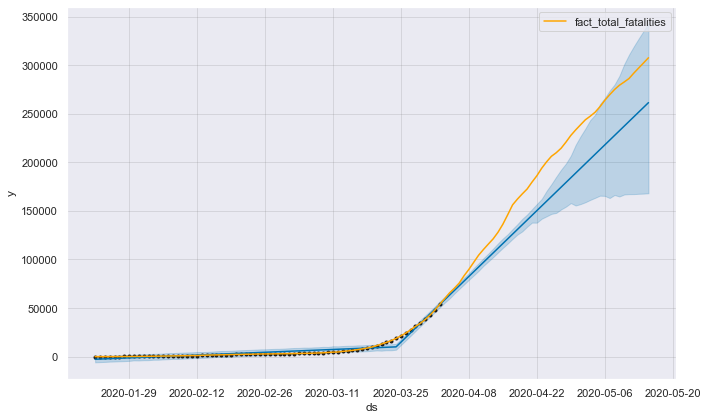

In [30]:
model.plot(forecast_total_fatalities)
sns.lineplot(covid_total_fatalities.ds, covid_total_fatalities.y, color='orange', label='fact_total_fatalities');

In [31]:
calc_mae_and_mape_metrics(covid_total_fatalities, forecast_total_fatalities)

MAPE = 15.095248907367335 %
MAE = 31436.72586094179


Действительно, подбор гиперпараметров помог улучшить качество модели, что мы можем наблюдать по вышепостроенному графику и полученным метрикам. MAE, например, после подбора гиперпараметров стала 31436 вместо 86888 в baseline-модели.

Но все же, хочется сделать модель ещё точнее. Подумаем о том, что на фатальные исходы `Fatalities` от **COVID-19** влияют количество подтвержденных заболеваний `ConfirmedCases`, которые мы прогнозировали ранее. Почему бы не попробовать добавить в модель этот регрессор?

#### Добавление регрессора

Создадим функцию `calc_prophet_forecast_with_regressor`, которая расширяет возможности функции `calc_prophet_forecast`, позволяя передавать дополнительный регрессор, который будет использоваться при обучении и создании прогноза.

В качестве параметров регрессору зададим **`prior_scale=0.5`** (добавляет дополнительную регуляризацию, т.к. по умолчанию этот параметр равен параметру `model.holidays_prior_scale=10`, который отвечает за эффекты праздников и практически не применяет регуляризацию, так как обычно у нас не очень много праздников, и мы можем хорошо оценить их влияние. В нашем случае необходимо добавить регуляризацию, чтобы не произошло переобучения) и **`mode='multiplicative'`**, чтобы эффект регрессора "умножил" тренд, поскольку на полученной выше модели можно заметить, что тренд сильно отстает от реальных значений.

In [32]:
def calc_prophet_forecast_with_regressor(data, params=None, regressor=None, predictions=43):
    """ Создание, обучение и расчёт прогноза модели Prophet с возможностью добавления регрессора. """
    if params:
        model = Prophet(**params)
    else:
        model = Prophet()

    if regressor is not None:
        data['regressor'] = regressor[:-predictions]
        model.add_regressor('regressor', prior_scale=0.5, mode='multiplicative')
    
    model.fit(data)
    
    if regressor is not None:
        future = model.make_future_dataframe(periods=predictions)
        future['regressor'] = regressor
    else:
        future = model.make_future_dataframe(periods=predictions)

    forecast = model.predict(future)
    return model, forecast


model, forecast_total_fatalities = calc_prophet_forecast_with_regressor(data=train_covid_total_fatalities, 
                                                                        params=params,
                                                                        regressor=forecast_total_confcases['yhat'])


Initial log joint probability = -79.7642
Iteration  1. Log joint probability =    32.8556. Improved by 112.62.
Iteration  2. Log joint probability =    74.8361. Improved by 41.9806.
Iteration  3. Log joint probability =     113.99. Improved by 39.1535.
Iteration  4. Log joint probability =    160.088. Improved by 46.0981.
Iteration  5. Log joint probability =    204.934. Improved by 44.846.
Iteration  6. Log joint probability =    226.395. Improved by 21.4608.
Iteration  7. Log joint probability =    232.493. Improved by 6.09829.
Iteration  8. Log joint probability =    236.958. Improved by 4.46512.
Iteration  9. Log joint probability =    237.279. Improved by 0.321315.
Iteration 10. Log joint probability =    237.427. Improved by 0.148176.
Iteration 11. Log joint probability =    237.721. Improved by 0.293948.
Iteration 12. Log joint probability =    237.794. Improved by 0.0725459.
Iteration 13. Log joint probability =    237.952. Improved by 0.15808.
Iteration 14. Log joint probabil

Посмотрим на прогноз модели, в которую был добавлен регрессор:

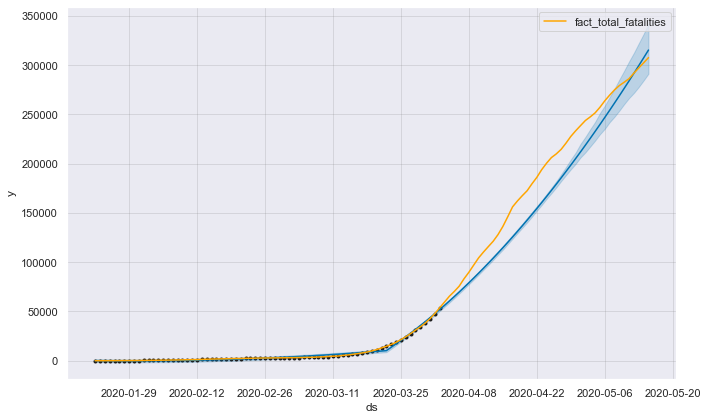

In [33]:
model.plot(forecast_total_fatalities)
sns.lineplot(covid_total_fatalities.ds, covid_total_fatalities.y, color='orange', label='fact_total_fatalities');

На графике заметно улучшение качества прогноза, однако предсказания к концу прогнозируемого периода начинают "обгонять" и иметь более крутой тренд, чем у реальных значений. Этот эффект сказывается из-за мультипликативного характера влияния регрессора. Таким образом, с данной настройкой влияния регрессора лучше не прогнозировать на длинный горизонт. На нашем же горизонте прогнозирования эта модель более выигрышная, убедимся в этом, рассчитав метрики:

In [34]:
calc_mae_and_mape_metrics(covid_total_fatalities, forecast_total_fatalities)

MAPE = 10.910367499796518 %
MAE = 18711.358262559406


Мы получили снижение метрики MAPE на 5% по сравнению с моделью с подобранными гиперпараметрами, и на 31% по сравнению с baseline-моделью, что можно считать довольно хорошим результатом.

Перейдём к анализу показателей `ConfirmedCases` и `Fatalities` в России.

### Russia Confirmed Cases

#### Baseline
Начинаем с baseline-модели "из коробки":

In [35]:
model, forecast = calc_prophet_forecast(train_covid_rus_confcases)


Initial log joint probability = -43.8241
Iteration  1. Log joint probability =    39.4918. Improved by 83.3159.
Iteration  2. Log joint probability =    75.4003. Improved by 35.9085.
Iteration  3. Log joint probability =      96.69. Improved by 21.2897.
Iteration  4. Log joint probability =    100.054. Improved by 3.36448.
Iteration  5. Log joint probability =    100.058. Improved by 0.00402414.
Iteration  6. Log joint probability =    100.318. Improved by 0.259775.
Iteration  7. Log joint probability =     100.37. Improved by 0.0520285.
Iteration  8. Log joint probability =    100.418. Improved by 0.0474115.
Iteration  9. Log joint probability =    100.449. Improved by 0.03166.
Iteration 10. Log joint probability =    100.484. Improved by 0.034882.
Iteration 11. Log joint probability =    100.491. Improved by 0.00679509.
Iteration 12. Log joint probability =    100.664. Improved by 0.173389.
Iteration 13. Log joint probability =    100.888. Improved by 0.22312.
Iteration 14. Log join

Сравним прогноз с реальными значениями:

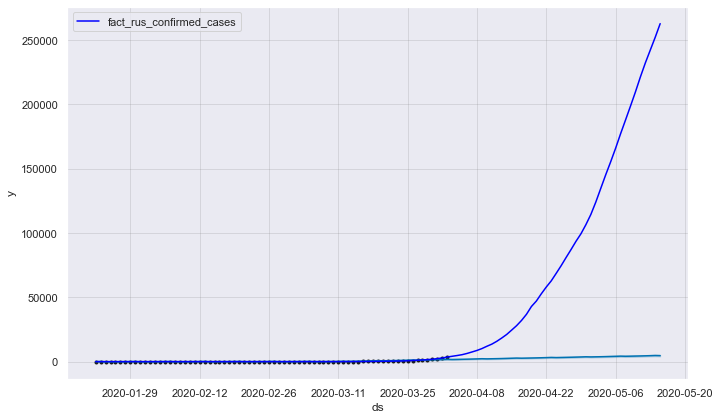

In [36]:
model.plot(forecast)
sns.lineplot(covid_rus_confcases.ds, covid_rus_confcases.y, color='blue', label='fact_rus_confirmed_cases');

В России COVID-19 стал распространяться чуть позднее, чем по миру, поэтому на начало периода прогнозирования тренд только начинал менять свое направление. Основная точка перелома тренда - `2020-04-10`, а её нет в обучающей выборке. Поэтому модель, конечно, не смогла сделать адекватный прогноз.

Посмотрим на **MAE** и **MAPE** для прогноза:

In [37]:
calc_mae_and_mape_metrics(covid_rus_confcases, forecast)

MAPE = 90.39912398755573 %
MAE = 88598.656797616


Получили совсем плачевные результаты. Поможет ли подбор гиперпараметров? Кажется, что нет, но попробуем.

#### Настройка гиперпараметров и кросс-валидация

In [38]:
param_grid = {
    'changepoints': [['2020-04-02']],
    'changepoint_prior_scale': [0.05, 0.1, 0.25, 0.5],
    'weekly_seasonality': [True, False],
}

params, mae, mape = tune_hyperparameters_with_crossval(covid_rus_confcases, param_grid)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36       210.517   3.18061e-05      0.026437      0.9677      0.9677       42   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -92.6927
Iteration  1. Log joint probability =    38.0494. Improved by 130.742.
Iteration  2. Log joint probability =    78.9931. Improved by 40.9437.
Iteration  3. Log joint probability =    89.9333. Improved by 10.9402.
Iteration  4. Log joint probability =    90.6518. Improved by 0.718522.
Iteration  5. Log joint probability =    90.7312. Improved by 0.0793382.
Iteration  6. Log joint probability =    91.3667. Improved by 0.635507.
Iteration  7. Log joint probability =    91.4631. Improved by 0.0964307.
Iteration  8. Log joint probability =    91.5118. Improved by 0.0486669.
Iteration  9. Log joint probability =    91.5361. Improved by 0.0243352.
Iteration 10. Log joint probability =    91.5622. Improved by 0.026082.
Iteration 11. Log joint probability =    91.5705. Improved by 0.00833575.
Iteration 12. Log joint probability =    91.5714. Improved by 0.000930663.
Iteration 13. Log joint probability =    91.5772. Improved by 0.00579872.
Iteration 14. 

 12%|█████▋                                       | 1/8 [00:01<00:11,  1.61s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21       210.286   0.000153728       0.02241      0.9889      0.9889       29   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -74.2825
Iteration  1. Log joint probability =    38.1046. Improved by 112.387.
Iteration  2. Log joint probability =    77.9347. Improved by 39.8301.
Iteration  3. Log joint probability =    89.9031. Improved by 11.9684.
Iteration  4. Log joint probability =    90.5172. Improved by 0.614135.
Iteration  5. Log joint probability =    90.5177. Improved by 0.000453341.
Iteration  6. Log joint probability =    90.5191. Improved by 0.00144535.
Iteration  7. Log joint probability =    90.5384. Improved by 0.0192773.
Iteration  8. Log joint probability =    90.5388. Improved by 0.000395432.
Iteration  9. Log joint probability =    90.5388. Improved by 5.15172e-05.
Iteration 10. Log joint probability =    90.5389. Improved by 4.54776e-06.
Iteration 11. Log joint probability =    90.5389. Improved by 1.43863e-06.
Iteration 12. Log joint probability =    90.5389. Improved by 6.42174e-08.
Iteration 13. Log joint probability =    90.5389. Improved by 1.85349e-07.
I

 25%|███████████▎                                 | 2/8 [00:03<00:09,  1.63s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       233.212     8.739e-05     0.0129752      0.9973      0.9973       36   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -93.3859
Iteration  1. Log joint probability =    38.0523. Improved by 131.438.
Iteration  2. Log joint probability =    78.9925. Improved by 40.9403.
Iteration  3. Log joint probability =    89.9301. Improved by 10.9375.
Iteration  4. Log joint probability =    90.6721. Improved by 0.74201.
Iteration  5. Log joint probability =    91.4435. Improved by 0.771424.
Iteration  6. Log joint probability =    91.5388. Improved by 0.095283.
Iteration  7. Log joint probability =    91.5531. Improved by 0.0143436.
Iteration  8. Log joint probability =    91.5583. Improved by 0.00517333.
Iteration  9. Log joint probability =    91.5754. Improved by 0.0171482.
Iteration 10. Log joint probability =    91.5944. Improved by 0.0190122.
Iteration 11. Log joint probability =    91.5965. Improved by 0.00201263.
Iteration 12. Log joint probability =    91.6066. Improved by 0.0101811.
Iteration 13. Log joint probability =    91.6068. Improved by 0.0001949.
Iteration 14. Log

 38%|████████████████▉                            | 3/8 [00:04<00:08,  1.66s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      26       233.006   2.19959e-05    0.00200051      0.4295      0.8243       35   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -74.9757
Iteration  1. Log joint probability =    38.1073. Improved by 113.083.
Iteration  2. Log joint probability =    77.9333. Improved by 39.8259.
Iteration  3. Log joint probability =    89.8994. Improved by 11.9662.
Iteration  4. Log joint probability =    90.5292. Improved by 0.629806.
Iteration  5. Log joint probability =    90.5346. Improved by 0.00540898.
Iteration  6. Log joint probability =    90.5349. Improved by 0.00022815.
Iteration  7. Log joint probability =    90.5388. Improved by 0.00390171.
Iteration  8. Log joint probability =    90.5388. Improved by 4.49642e-05.
Iteration  9. Log joint probability =    90.5388. Improved by 1.92988e-05.
Iteration 10. Log joint probability =    90.5389. Improved by 1.24325e-05.
Iteration 11. Log joint probability =    90.5389. Improved by 3.63328e-06.
Iteration 12. Log joint probability =    90.5389. Improved by 4.29955e-06.
Iteration 13. Log joint probability =    90.5389. Improved by 1.71257e-06.
I

 50%|██████████████████████▌                      | 4/8 [00:06<00:06,  1.65s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       247.243    1.9453e-05     0.0507691           1           1       39   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -94.3022
Iteration  1. Log joint probability =    38.0609. Improved by 132.363.
Iteration  2. Log joint probability =    78.9474. Improved by 40.8865.
Iteration  3. Log joint probability =    78.9609. Improved by 0.0135216.
Iteration  4. Log joint probability =    89.8675. Improved by 10.9066.
Iteration  5. Log joint probability =    89.8858. Improved by 0.0183191.
Iteration  6. Log joint probability =    89.8917. Improved by 0.00589577.
Iteration  7. Log joint probability =    89.8975. Improved by 0.00584606.
Iteration  8. Log joint probability =    90.6522. Improved by 0.754664.
Iteration  9. Log joint probability =    91.5933. Improved by 0.941107.
Iteration 10. Log joint probability =    91.6042. Improved by 0.0108521.
Iteration 11. Log joint probability =     91.607. Improved by 0.00286379.
Iteration 12. Log joint probability =    91.6071. Improved by 2.11892e-05.
Iteration 13. Log joint probability =    91.6072. Improved by 0.000186402.
Iteration 

 62%|████████████████████████████▏                | 5/8 [00:08<00:04,  1.65s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      25       247.052   0.000135023    0.00231352       0.993       0.993       32   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -78.9836
Iteration  1. Log joint probability =     39.663. Improved by 118.647.
Iteration  2. Log joint probability =    75.0893. Improved by 35.4263.
Iteration  3. Log joint probability =     75.094. Improved by 0.00471657.
Iteration  4. Log joint probability =    75.1206. Improved by 0.0265804.
Iteration  5. Log joint probability =    75.1274. Improved by 0.00678067.
Iteration  6. Log joint probability =    75.1516. Improved by 0.024292.
Iteration  7. Log joint probability =    75.1605. Improved by 0.00883431.
Iteration  8. Log joint probability =    75.1825. Improved by 0.022018.
Iteration  9. Log joint probability =    75.1934. Improved by 0.0108777.
Iteration 10. Log joint probability =    75.2131. Improved by 0.0197581.
Iteration 11. Log joint probability =     75.226. Improved by 0.0129109.
Iteration 12. Log joint probability =    75.2436. Improved by 0.0175121.
Iteration 13. Log joint probability =    75.2585. Improved by 0.0149341.
Iteration 14

 75%|█████████████████████████████████▊           | 6/8 [00:09<00:03,  1.65s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      25       251.988    0.00030344     0.0119931           1           1       30   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -94.9953
Iteration  1. Log joint probability =    38.0752. Improved by 133.071.
Iteration  2. Log joint probability =    72.3481. Improved by 34.2729.
Iteration  3. Log joint probability =    77.3182. Improved by 4.97015.
Iteration  4. Log joint probability =    80.0192. Improved by 2.70097.
Iteration  5. Log joint probability =    81.5929. Improved by 1.57371.
Iteration  6. Log joint probability =     82.351. Improved by 0.758094.
Iteration  7. Log joint probability =    83.4478. Improved by 1.09681.
Iteration  8. Log joint probability =    89.6916. Improved by 6.24375.
Iteration  9. Log joint probability =    89.9443. Improved by 0.252706.
Iteration 10. Log joint probability =    89.9839. Improved by 0.0396489.
Iteration 11. Log joint probability =    89.9975. Improved by 0.0136084.
Iteration 12. Log joint probability =    90.0091. Improved by 0.0115226.
Iteration 13. Log joint probability =    90.0108. Improved by 0.00177627.
Iteration 14. Log joint 

 88%|███████████████████████████████████████▍     | 7/8 [00:11<00:01,  1.65s/it]

Initial log joint probability = -12.2215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21       251.801   9.28587e-05     0.0672886      0.9817      0.9817       28   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.



Initial log joint probability = -79.6767
Iteration  1. Log joint probability =    39.6782. Improved by 119.355.
Iteration  2. Log joint probability =    70.6258. Improved by 30.9476.
Iteration  3. Log joint probability =    71.6304. Improved by 1.0046.
Iteration  4. Log joint probability =    82.4018. Improved by 10.7714.
Iteration  5. Log joint probability =    89.4273. Improved by 7.02554.
Iteration  6. Log joint probability =    89.7424. Improved by 0.315026.
Iteration  7. Log joint probability =    92.7276. Improved by 2.98521.
Iteration  8. Log joint probability =    92.7383. Improved by 0.0107254.
Iteration  9. Log joint probability =    92.7767. Improved by 0.0383644.
Iteration 10. Log joint probability =    92.8914. Improved by 0.114733.
Iteration 11. Log joint probability =     92.912. Improved by 0.0205915.
Iteration 12. Log joint probability =    92.9143. Improved by 0.00230274.
Iteration 13. Log joint probability =    92.9242. Improved by 0.00987877.
Iteration 14. Log join

100%|█████████████████████████████████████████████| 8/8 [00:13<00:00,  1.65s/it]


In [39]:
print('Подобранные параметры:', params)
print('MAPE =', mape * 100, '%')

Подобранные параметры: {'changepoints': ['2020-04-02'], 'changepoint_prior_scale': 0.5, 'weekly_seasonality': False}
MAPE = 95.84942744970995 %


Как и предполагалось, подбор параметров не помог. Наоборот, метрика MAPE упала на 5%. Остаётся один вариант для спасения нашего прогноза, обсудим его ниже.

#### Добавление регрессоров

Но ведь на значение подтверждённых случаев COVID-19 в России могут влиять подтверждённые случаи во всем мире `forecast_total_confcases` и фатальные исходные во всём мире `forecast_total_fatalities`, которые мы спрогнозировали выше. Добавим эти данные в baseline-модель как 2 регрессора. При этом не будем штрафовать модель за переобучение, то есть за сильное подстраивание под значения регрессоров (`prior_scale=10`), и установим `mode='multiplicative'`, чтобы эффект каждого регрессора "умножил" тренд, поскольку baseline-модели не за что зацепиться на обучающей выборке, а мы вряд ли верим в то, что COVID-19 обойдёт Россию стороной.

Попробуем добавить в модель 2 регрессора и сделать прогноз:

In [40]:
model = Prophet()

train_covid_rus_confcases['total_confcases'] = forecast_total_confcases['yhat'][:-43]
train_covid_rus_confcases['total_fatalities'] = forecast_total_fatalities['yhat'][:-43]

model.add_regressor('total_confcases', prior_scale=10, mode='multiplicative')
model.add_regressor('total_fatalities', prior_scale=10, mode='multiplicative')

model.fit(train_covid_rus_confcases)

future = model.make_future_dataframe(periods=43)
future['total_confcases'] = forecast_total_confcases['yhat']
future['total_fatalities'] = forecast_total_fatalities['yhat']

forecast_rus_confcases = model.predict(future)


Initial log joint probability = -50.2671
Iteration  1. Log joint probability =    26.2034. Improved by 76.4705.
Iteration  2. Log joint probability =    68.6047. Improved by 42.4013.
Iteration  3. Log joint probability =    121.657. Improved by 53.0527.
Iteration  4. Log joint probability =    139.965. Improved by 18.3081.
Iteration  5. Log joint probability =    168.245. Improved by 28.2791.
Iteration  6. Log joint probability =    168.336. Improved by 0.0916292.
Iteration  7. Log joint probability =     168.43. Improved by 0.0936937.
Iteration  8. Log joint probability =    168.713. Improved by 0.28316.
Iteration  9. Log joint probability =    168.741. Improved by 0.0284064.
Iteration 10. Log joint probability =    168.896. Improved by 0.154979.
Iteration 11. Log joint probability =    169.129. Improved by 0.233008.
Iteration 12. Log joint probability =    169.634. Improved by 0.504872.
Iteration 13. Log joint probability =    202.061. Improved by 32.4264.
Iteration 14. Log joint pr

Посмотрим на получившийся прогноз и реальные данные:

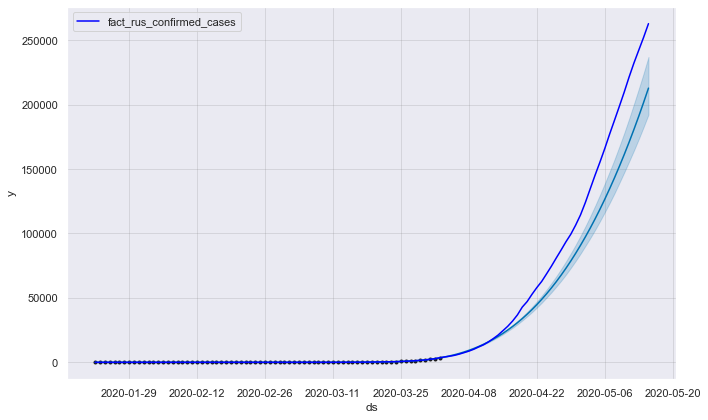

In [41]:
model.plot(forecast_rus_confcases)
sns.lineplot(covid_rus_confcases.ds, covid_rus_confcases.y, color='blue', label='fact_rus_confirmed_cases');

Удивительно, какой вклад внесли регрессоры, наша гипотеза об их влиянии оказалась верной. Посмотрим, насколько нам удалось улучшить качество:

In [42]:
calc_mae_and_mape_metrics(covid_rus_confcases, forecast_rus_confcases)

MAPE = 16.321005702973753 %
MAE = 19499.26340098471


MAPE = 16.3% против 90% и MAE = 19500 против 88500 в baseline. Значения метрик, конечно, оставляют желать лучшего, но с учётом данных в обучающей выборке - хороший результат! 

Перейдём к построению модели для фатальных исходов `Fatalities` от COVID-19 в России.

### Russia Fatalities

#### Baseline

Делаем уже привычные для нас действия:

In [43]:
model, forecast = calc_prophet_forecast(train_covid_rus_fatalities)


Initial log joint probability = -44.9365
Iteration  1. Log joint probability =    33.8655. Improved by 78.8019.
Iteration  2. Log joint probability =     80.356. Improved by 46.4905.
Iteration  3. Log joint probability =      100.2. Improved by 19.8438.
Iteration  4. Log joint probability =    101.854. Improved by 1.65464.
Iteration  5. Log joint probability =    101.943. Improved by 0.0887448.
Iteration  6. Log joint probability =    101.991. Improved by 0.0476442.
Iteration  7. Log joint probability =     102.04. Improved by 0.0490845.
Iteration  8. Log joint probability =    102.225. Improved by 0.185386.
Iteration  9. Log joint probability =    102.325. Improved by 0.0994173.
Iteration 10. Log joint probability =     102.35. Improved by 0.02485.
Iteration 11. Log joint probability =    102.362. Improved by 0.0124244.
Iteration 12. Log joint probability =    102.466. Improved by 0.104318.
Iteration 13. Log joint probability =    102.492. Improved by 0.0260701.
Iteration 14. Log joi

Сравним прогноз с реальными значениями:

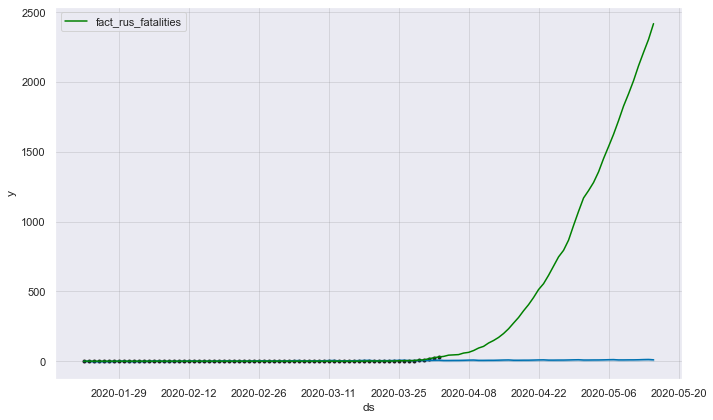

In [44]:
model.plot(forecast)
sns.lineplot(covid_rus_fatalities.ds, covid_rus_fatalities.y, color='green', label='fact_rus_fatalities');

Видим ту же проблему: в России COVID-19 стал распространяться чуть позднее, чем по миру, поэтому на начало периода прогнозирования тренд только начинал менять свое направление. Основная точка перелома тренда - `2020-04-13`, а её нет в обучающей выборке. Поэтому ждать адекватного прогноза от baseline-модели бессмысленно.

Но мы уже знаем, что эту проблему не решить подбором гиперпараметров, поэтому посмотрим на метрики качества полученной модели и подумаем насчёт регрессоров:

In [45]:
calc_mae_and_mape_metrics(covid_rus_fatalities, forecast)

MAPE = 96.6623202194616 %
MAE = 834.5867024690725


#### Добавление регрессора

Так как сейчас мы прогнозируем число фатальных случаев COVID-19 для России, то в качестве регрессора разумно использовать показатель подтверждённых заболеваний по России, которые мы уже спрогнозировали (`forecast_rus_confcases`). При этом не будем штрафовать модель за переобучение, то есть за сильное подстраивание под значения регрессора (`prior_scale=10`).

Попробуем добавить в модель регрессор и сделать прогноз:

In [46]:
model = Prophet()

train_covid_rus_fatalities['rus_confcases'] = forecast_rus_confcases['yhat'][:-43]
model.add_regressor('rus_confcases', prior_scale=10)

model.fit(train_covid_rus_fatalities)

future = model.make_future_dataframe(periods=43)
future['rus_confcases'] = forecast_rus_confcases['yhat']

forecast_rus_fatalities = model.predict(future)


Initial log joint probability = -48.158
Iteration  1. Log joint probability =    33.5792. Improved by 81.7372.
Iteration  2. Log joint probability =    116.325. Improved by 82.7459.
Iteration  3. Log joint probability =    166.094. Improved by 49.7693.
Iteration  4. Log joint probability =    191.751. Improved by 25.6568.
Iteration  5. Log joint probability =    195.955. Improved by 4.20391.
Iteration  6. Log joint probability =    196.026. Improved by 0.0708465.
Iteration  7. Log joint probability =    196.158. Improved by 0.13166.
Iteration  8. Log joint probability =    196.212. Improved by 0.0546546.
Iteration  9. Log joint probability =    196.406. Improved by 0.193769.
Iteration 10. Log joint probability =    196.564. Improved by 0.157883.
Iteration 11. Log joint probability =    196.864. Improved by 0.300384.
Iteration 12. Log joint probability =    198.004. Improved by 1.13978.
Iteration 13. Log joint probability =    199.354. Improved by 1.34967.
Iteration 14. Log joint proba

Посмотрим на получившийся прогноз и реальные данные:

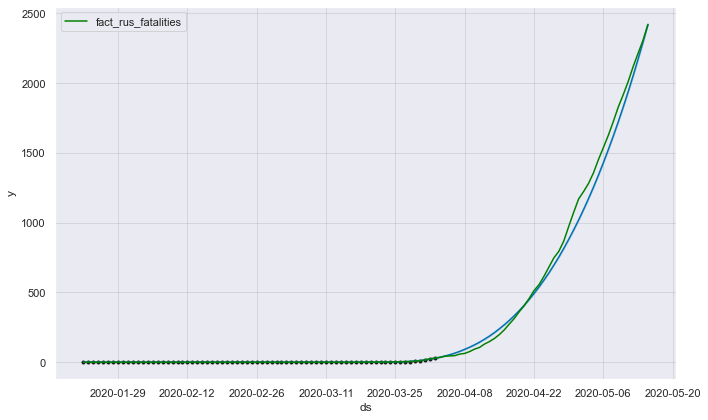

In [47]:
model.plot(forecast_rus_fatalities)
sns.lineplot(covid_rus_fatalities.ds, covid_rus_fatalities.y, color='green', label='fact_rus_fatalities');

Видим, что добавление регрессора серьёзно помогло улучшить качество прогноза. Посмотрим на метрики:

In [48]:
calc_mae_and_mape_metrics(covid_rus_fatalities, forecast_rus_fatalities)

MAPE = 12.439001606753868 %
MAE = 51.16043439008265


С учётом того, что в обучающей выборке были очень слабые намеки на изменение тренда, добавление регрессора позволило сильно улучшить качество по сравнению с baseline'ом - MAPE уменьшился почти в 9 раз (12% против 96%), MAE - в 40 раз (51 против 834).

## Итог

Метод `Prophet` может показывать достойные результаты прогнозирования. Но как и остальные методы, нуждается в грамотной настройке со стороны исследователя. Прогнозы "из коробки" почти во всех случаях оказались сильно хуже, однако их удобно использовать в качестве baseline'а, проверяя гипотезы для улучшения модели.